![截圖 2025-05-19 下午5.22.43.png](<attachment:截圖 2025-05-19 下午5.22.43.png>)
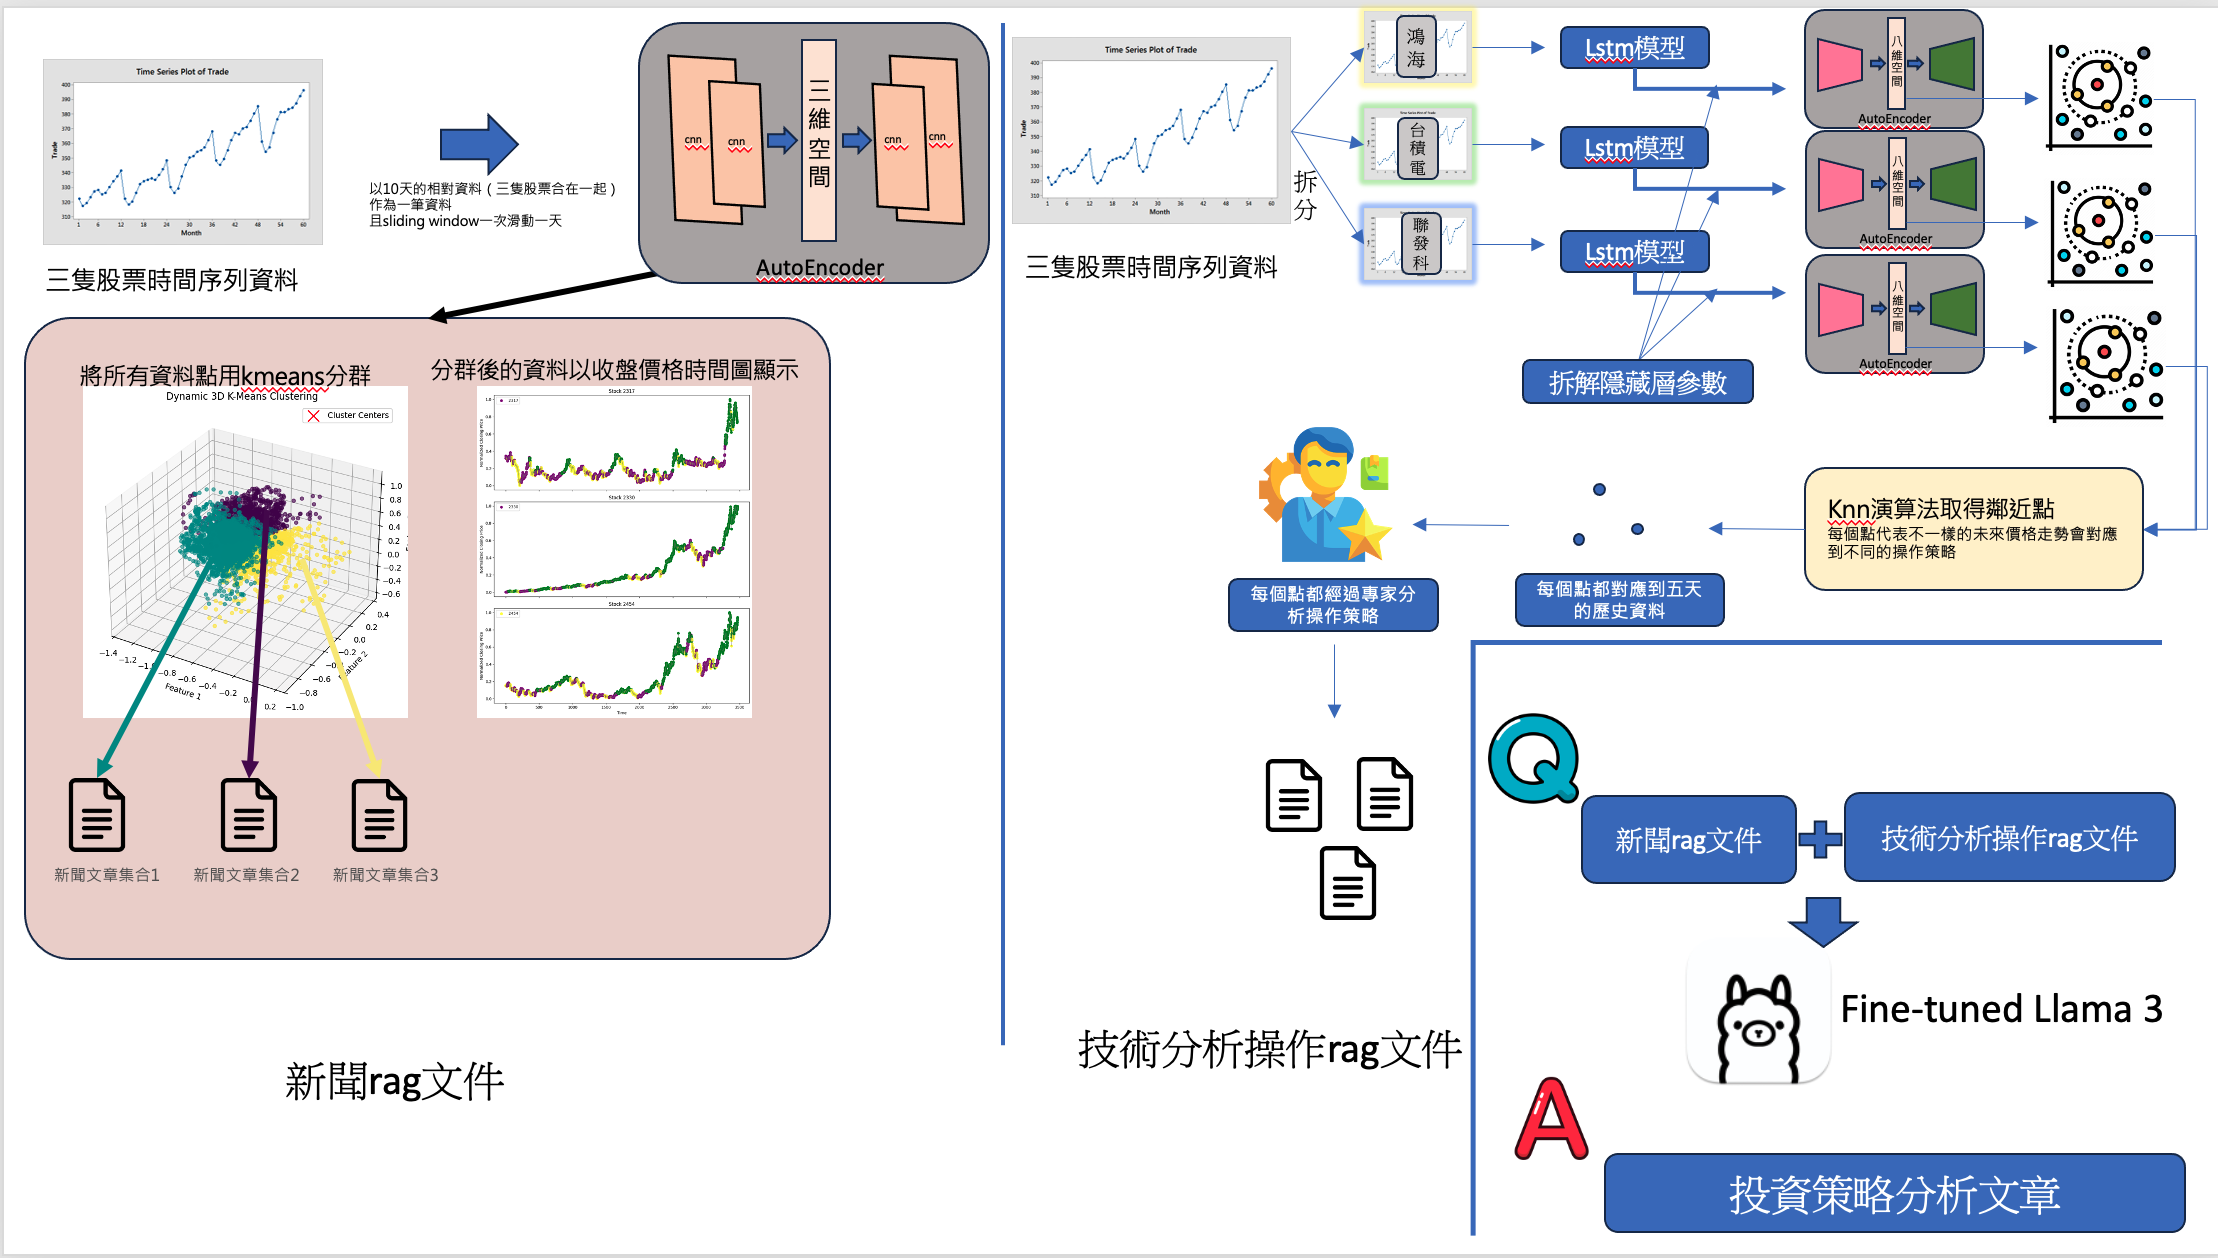

獲得推論用資料

一、新聞文章部份

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

In [16]:
# 讀取 CSV 檔案
file_path = "../1.資料前處理/merged_stocks_sorted(移除川普影響).csv"
df = pd.read_csv(file_path)
print(df.head())

           日期      成交股數        成交金額    開盤價    最高價    最低價    收盤價  漲跌價差  成交筆數  \
0  2010-10-21  20697571  2347730094  114.0  114.5  112.5  113.0    -1  9188   
1  2010-10-21  40237461  2458712121   61.3   61.4   60.8   61.0     0  7376   
2  2010-10-21   9435865  3675093620  394.0  395.0  386.0  387.0  -5.5  6346   
3  2010-10-22  16111879  1833691206  114.5  114.5  113.0  114.0     1  6509   
4  2010-10-22  42971490  2646457386   61.7   61.8   61.4   61.8   0.8  9208   

    SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI       MACD  \
0  113.60  ...  129.9400  113.598253  115.156901  42.888466  -1.067839   
1   61.02  ...   60.9100   61.022536   61.126968  49.448148   0.078879   
2  385.20  ...  496.8100  389.029298  412.053709  32.870088 -18.545872   
3  113.20  ...  129.7525  113.732169  115.046720  45.751457  -1.032347   
4   61.00  ...   60.8945   61.281691   61.191067  55.601780   0.124750   

   MACD_signal  MACD_hist  Support_Level  Resistance_Level  股票代碼  
0    -0.84674

計算與上個交易日的價格變化

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 確保日期是正確的格式並排序
df['日期'] = pd.to_datetime(df['日期'])
df = df.sort_values(by=['日期','股票代碼'])

# 定義需要計算變化的數值型欄位
numeric_cols = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 
                'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 
                'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level']

# 數據前處理
df[numeric_cols] = df[numeric_cols].replace("X0.00", "0")

# 移除 `,` 並轉換為 float
for col in numeric_cols:
    df[col] = df[col].astype(str).str.replace(',', '').astype(float)


# 創建合併後的 DataFrame，首先複製原始數據
merged_df = df.copy()

# 對漲跌價差進行 MinMax 縮放 (針對每支股票分別處理)
scaler = MinMaxScaler()
for stock_id in merged_df['股票代碼'].unique():
    mask = merged_df['股票代碼'] == stock_id
    # 將漲跌價差重塑為二維陣列（sklearn要求的格式）
    price_diff = merged_df.loc[mask, '漲跌價差'].values.reshape(-1, 1)
    # 進行 MinMax 縮放
    scaled_diff = scaler.fit_transform(price_diff)
    # 將縮放後的值存回 DataFrame
    merged_df.loc[mask, '漲跌價差_pct'] = scaled_diff.flatten()

# 計算其他欄位的百分比變化
for col in [c for c in numeric_cols if c != '漲跌價差']:
    merged_df[f'{col}_pct'] = df.groupby('股票代碼')[col].pct_change() * 100



# 移除含有 NaN 的行
merged_df = merged_df.dropna()

# 查看結果
print("合併後資料的前5筆：")
print(merged_df.head())

# 檢查資料形狀
print("\n資料形狀：", merged_df.shape)

# 檢查是否有任何無限值
inf_count = np.sum(np.isinf(merged_df.select_dtypes(include=[np.number])))
print("\n無限值數量：", inf_count)

# 儲存結果
merged_df.to_csv('新聞部份/stock_data_with_changes.csv', index=False)

# 顯示各欄位數據類型
print("\n各欄位數據類型：")
print(merged_df.dtypes)

合併後資料的前5筆：
          日期        成交股數          成交金額    開盤價    最高價    最低價    收盤價  漲跌價差  \
3 2010-10-22  16111879.0  1.833691e+09  114.5  114.5  113.0  114.0   1.0   
4 2010-10-22  42971490.0  2.646457e+09   61.7   61.8   61.4   61.8   0.8   
5 2010-10-22   7146883.0  2.771465e+09  392.5  392.5  382.5  387.0   0.0   
6 2010-10-25  46473212.0  5.436269e+09  114.0  118.5  114.0  118.5   4.5   
7 2010-10-25  38700363.0  2.398665e+09   62.0   62.2   61.8   62.0   0.2   

      成交筆數  SMA_5  ...  SMA_50_pct  SMA_200_pct  EMA_5_pct  EMA_20_pct  \
3   6509.0  113.2  ...   -0.271370    -0.144297   0.117885   -0.095679   
4   9208.0   61.0  ...    0.052880    -0.025447   0.424687    0.104861   
5   4775.0  384.6  ...   -0.325667    -0.181156  -0.173877   -0.579067   
6  22716.0  114.3  ...   -0.204082    -0.131019   1.397386    0.285870   
7  10753.0   61.3  ...    0.062762    -0.020527   0.390714    0.125903   

     RSI_pct   MACD_pct  MACD_signal_pct  MACD_hist_pct  Support_Level_pct  \
3   6.675

/home/r11011101/anaconda3/envs/myenv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)




各欄位數據類型：
日期                      datetime64[ns]
成交股數                           float64
成交金額                           float64
開盤價                            float64
最高價                            float64
最低價                            float64
收盤價                            float64
漲跌價差                           float64
成交筆數                           float64
SMA_5                          float64
SMA_20                         float64
SMA_60                         float64
SMA_50                         float64
SMA_200                        float64
EMA_5                          float64
EMA_20                         float64
RSI                            float64
MACD                           float64
MACD_signal                    float64
MACD_hist                      float64
Support_Level                  float64
Resistance_Level               float64
股票代碼                             int64
漲跌價差_pct                       float64
成交股數_pct                       float64
成交金額_pct       

In [18]:
def create_sequences(df, seq_length=10):
    sequences = []
    start_dates = []
    stock_ids = []
    close_prices = []  # 新增收盤價列表
    
    # 只選取需要的欄位 (保留股票代碼和收盤價)
    features = [col for col in df.columns if col.endswith('_pct')]
    df = df[['日期', '股票代碼', '收盤價'] + features]
    
    # 輸出除錯資訊
    print(f"特徵數量: {len(features)}")
    print(f"特徵名稱: {features}")
    
    # 對每個股票分別處理
    for stock_id in df['股票代碼'].unique():
        stock_data = df[df['股票代碼'] == stock_id].sort_values('日期')
        print(f"\n處理股票 {stock_id}")
        print(f"該股票資料筆數: {len(stock_data)}")
        
        # 創建滑動窗口
        for i in range(len(stock_data) - seq_length + 1):
            # 取得當前窗口的數據
            sequence = stock_data.iloc[i:i+seq_length]
            
            # 檢查是否有足夠的數據點
            if len(sequence) == seq_length:
                # 保留特徵數據和股票代碼
                seq_features = sequence[features].values
                sequences.append(seq_features)
                # 記錄序列的起始日期、股票代碼和收盤價
                dates = pd.to_datetime(sequence['日期'])
                start_dates.append(dates.iloc[0])
                stock_ids.append(stock_id)
                close_prices.append(sequence['收盤價'].iloc[0])  # 添加起始日的收盤價
                
                if len(sequences) == 1:  # 輸出第一個成功的序列資訊
                    print(f"成功創建第一個序列，形狀: {seq_features.shape}")
                    print(f"序列日期範圍: {dates.iloc[0]} 到 {dates.iloc[-1]}")
                    print(f"起始日收盤價: {close_prices[0]}")
        
        print(f"該股票產生的序列數: {sum(1 for x in stock_ids if x == stock_id)}")
    
    # 檢查是否有序列被創建
    if not sequences:
        print("警告：沒有找到符合條件的序列")
        return pd.DataFrame()
    
    # 轉換為 numpy array
    sequences = np.array(sequences)
    
    # 創建包含起始日期、股票代碼和收盤價的 DataFrame
    sequences_df = pd.DataFrame({
        'start_date': start_dates,
        'stock_id': stock_ids,
        'close_price': close_prices,  # 添加收盤價欄位
        'sequence': list(sequences)
    })
    
    return sequences_df

# 創建序列數據
sequences_df = create_sequences(merged_df)

# 顯示結果
if not sequences_df.empty:
    print("\n成功創建序列:")
    print(f"序列數據總數: {len(sequences_df)}")
    print("\n前幾筆資料:")
    print(sequences_df[['start_date', 'stock_id', 'close_price']].head())
    print("\n第一個序列的形狀:", sequences_df['sequence'].iloc[0].shape)

特徵數量: 21
特徵名稱: ['漲跌價差_pct', '成交股數_pct', '成交金額_pct', '開盤價_pct', '最高價_pct', '最低價_pct', '收盤價_pct', '成交筆數_pct', 'SMA_5_pct', 'SMA_20_pct', 'SMA_60_pct', 'SMA_50_pct', 'SMA_200_pct', 'EMA_5_pct', 'EMA_20_pct', 'RSI_pct', 'MACD_pct', 'MACD_signal_pct', 'MACD_hist_pct', 'Support_Level_pct', 'Resistance_Level_pct']

處理股票 2317
該股票資料筆數: 3308
成功創建第一個序列，形狀: (10, 21)
序列日期範圍: 2010-10-22 00:00:00 到 2010-11-04 00:00:00
起始日收盤價: 114.0
該股票產生的序列數: 3299

處理股票 2330
該股票資料筆數: 3315
該股票產生的序列數: 3306

處理股票 2454
該股票資料筆數: 3314
該股票產生的序列數: 3305

成功創建序列:
序列數據總數: 9910

前幾筆資料:
  start_date  stock_id  close_price
0 2010-10-22      2317        114.0
1 2010-10-25      2317        118.5
2 2010-10-26      2317        118.0
3 2010-10-27      2317        116.0
4 2010-10-28      2317        116.5

第一個序列的形狀: (10, 21)


In [19]:
print(sequences_df.head())
print(sequences_df.tail())
print(sequences_df['sequence'].iloc[0].shape)
print(sequences_df['sequence'].iloc[0])
print(sequences_df.shape)
#sequences_df.to_csv('sequences_df.csv', index=False)

  start_date  stock_id  close_price  \
0 2010-10-22      2317        114.0   
1 2010-10-25      2317        118.5   
2 2010-10-26      2317        118.0   
3 2010-10-27      2317        116.0   
4 2010-10-28      2317        116.5   

                                            sequence  
0  [[0.4811320754716981, -22.155701265621943, -21...  
1  [[0.6462264150943396, 188.44067163116108, 196....  
2  [[0.41037735849056606, -62.00692347238663, -61...  
3  [[0.339622641509434, -8.911380065576601, -9.64...  
4  [[0.45754716981132076, 62.35554763007958, 62.1...  
     start_date  stock_id  close_price  \
9905 2024-04-11      2454       1200.0   
9906 2024-04-12      2454       1180.0   
9907 2024-04-15      2454       1110.0   
9908 2024-04-16      2454       1055.0   
9909 2024-04-17      2454       1050.0   

                                               sequence  
9905  [[0.4623655913978495, -4.199094107782598, -3.5...  
9906  [[0.32795698924731187, -16.64669417391694, -18...  
9907  [[

In [20]:
from sklearn.preprocessing import MinMaxScaler

def preprocess_sequences(sequences_df):
    # 取得所有序列
    all_sequences = np.stack(sequences_df['sequence'].values)
    
    # 重塑數據以便進行標準化 (samples * timesteps, features)
    original_shape = all_sequences.shape
    reshaped_sequences = all_sequences.reshape(-1, original_shape[2])
    
    # 對除了漲跌價差以外的特徵進行標準化
    scaler = MinMaxScaler()
    # 跳過第一個特徵(漲跌價差)，只標準化其他特徵
    reshaped_sequences[:, 1:] = scaler.fit_transform(reshaped_sequences[:, 1:])
    
    # 重塑回原始形狀
    processed_sequences = reshaped_sequences.reshape(original_shape)
    
    # 更新序列資料
    sequences_df['sequence'] = list(processed_sequences)
    
    return sequences_df, scaler

# 處理數據
processed_sequences_df_推論, scaler = preprocess_sequences(sequences_df)

# 檢查處理後的結果
print("處理後的第一個序列:")
print(processed_sequences_df_推論['sequence'].iloc[0])
print(processed_sequences_df_推論.head())

處理後的第一個序列:
[[0.48113208 0.04873415 0.04846365 0.48783055 0.51470588 0.53420678
  0.58480991 0.05029436 0.52115568 0.46192966 0.37485154 0.36544179
  0.28963732 0.58924499 0.48273116 0.33696923 0.90005012 0.16481912
  0.97545864 0.55209007 0.32033602]
 [0.64622642 0.19278866 0.19648508 0.45783658 0.65148985 0.54882626
  0.70030149 0.29222621 0.64673903 0.51302485 0.41578828 0.39246209
  0.30453597 0.71036048 0.57010749 0.43246693 0.89997297 0.16466325
  0.97540813 0.61315813 0.32431668]
 [0.41037736 0.02147467 0.02148467 0.62309878 0.53122673 0.60679235
  0.53552343 0.02272758 0.65415135 0.50279168 0.38396042 0.37860816
  0.30650775 0.6513734  0.55425214 0.28510669 0.89996092 0.16457252
  0.97548983 0.60092762 0.3248435 ]
 [0.33962264 0.05779368 0.05676817 0.44400415 0.51470588 0.49109138
  0.48751625 0.05977158 0.58741088 0.48234854 0.3551289  0.36808974
  0.3041526  0.57226787 0.51170523 0.24646278 0.90001816 0.16456293
  0.97546517 0.57649434 0.32421425]
 [0.45754717 0.10654249 0.105

In [21]:
# 推論用程式碼
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import plotly.express as px

# 定義相同的 CNN Autoencoder 架構
class CNNAutoEncoder(nn.Module):
    def __init__(self, seq_length=10, n_features=21):
        super(CNNAutoEncoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=n_features, 
                     out_channels=32, 
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            nn.Conv1d(in_channels=32,
                     out_channels=16,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(16 * seq_length, 3)
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(3, 16 * seq_length),
            nn.ReLU(),
            
            nn.Unflatten(1, (16, seq_length)),
            
            nn.ConvTranspose1d(16, 32,
                             kernel_size=3,
                             stride=1,
                             padding=1),
            nn.ReLU(),
            
            nn.ConvTranspose1d(32, n_features,
                             kernel_size=3,
                             stride=1,
                             padding=1)
        )
    
    def forward(self, x):
        x = x.transpose(1, 2)
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        x_reconstructed = x_reconstructed.transpose(1, 2)
        return x_reconstructed, z

# 推論函數
def inference(processed_sequences_df_推論):
    # 準備資料
    sequences = np.stack(processed_sequences_df_推論['sequence'].values)
    data_tensor = torch.FloatTensor(sequences)
    
    # 設定裝置
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 載入模型
    model = CNNAutoEncoder(seq_length=10, n_features=21)
    model.load_state_dict(torch.load("../3.訓練AutoEncoder建立新聞文章空間/cnn_autoencoder_model.pth"))
    model.to(device)
    model.eval()
    
    # 進行推論
    encoded_features = []
    with torch.no_grad():
        for batch in torch.split(data_tensor, 32):  # 批次大小為32
            batch = batch.to(device)
            _, z = model(batch)
            encoded_features.append(z.cpu().numpy())
    
    # 合併所有特徵
    encoded_features = np.concatenate(encoded_features, axis=0)
    
    # 創建結果DataFrame
    results_df = pd.DataFrame({
        'start_date': processed_sequences_df_推論['start_date'],
        'stock_id': processed_sequences_df_推論['stock_id'],
        'Feature1': encoded_features[:, 0],
        'Feature2': encoded_features[:, 1],
        'Feature3': encoded_features[:, 2]
    })
    
    # 使用Plotly繪製3D視覺化
    fig = px.scatter_3d(
        results_df, 
        x='Feature1', 
        y='Feature2', 
        z='Feature3',
        hover_data=['stock_id', 'start_date']
    )
    fig.show()
    
    return results_df, encoded_features

# 執行推論
results_df, encoded_features = inference(processed_sequences_df_推論)

# 儲存結果
results_df.to_csv('新聞部份/inference_results.csv', index=False)
print("\n推論結果已儲存至 inference_results.csv")




推論結果已儲存至 inference_results.csv


獲取原始空間資訊

In [22]:
import pandas as pd

# 讀取 CSV 檔案
df_original = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-1畫圖用notebook還有檔案/合併推論用.csv')

df_inference = pd.read_csv('新聞部份/inference_results.csv')

# 顯示前五筆資料
print(df_original.head())
print(df_inference.head())

   start_date  stock_id  close_price  \
0  2010-10-22      2317        114.0   
1  2010-10-25      2317        118.5   
2  2010-10-26      2317        118.0   
3  2010-10-27      2317        116.0   
4  2010-10-28      2317        116.5   

                                            sequence  Feature1  Feature2  \
0  [[0.59090909 0.04873415 0.04846365 0.48783055 ... -0.675784  0.014135   
1  [[0.6969697  0.19278866 0.19648508 0.45783658 ... -0.673951  0.011014   
2  [[0.54545455 0.02147467 0.02148467 0.62309878 ... -0.668412 -0.000567   
3  [[0.5        0.05779368 0.05676817 0.44400415 ... -0.665436 -0.008124   
4  [[0.57575758 0.10654249 0.10544773 0.41471947 ... -0.671571 -0.009925   

   Feature3  Cluster  
0  0.259927        0  
1  0.275752        0  
2  0.266177        0  
3  0.256095        0  
4  0.259675        0  
   start_date  stock_id  Feature1  Feature2  Feature3
0  2010-10-22      2317  0.381819 -0.056686  0.427373
1  2010-10-25      2317  0.394044 -0.046968  0.414511
2 

綁定原始資料空間內的資料點與新聞文章

1.2317部份

In [23]:
df_news2317 = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-2爬蟲爬取股票新聞資料/鴻海爬到的新聞資料還有內文/鴻海_新聞_擷取結果_已過濾.csv')
print(df_news2317.head())
print(df_original.head())

   date keyword                                title  \
0   NaN   鴻海 財經              知名部落客綠角 買ETF跟著指數賺 不用設停損   
1   NaN   鴻海 財經  基金女王不急著教女兒理財 林寶珠：一知半解的金融知識 反而容易揠苗助長   
2   NaN   鴻海 財經                       郭董諷巴菲特 有內線我也是神   
3   NaN   鴻海 財經                     「五股」小股東鬧場 郭董怒斥閃開   
4   NaN   鴻海 財經                        外資大提款 宏達電跌破千元   

                                                link publish_date  \
0  https://www.wealth.com.tw/articles/de60abf4-f4...   2011年1月11日   
1  https://www.wealth.com.tw/articles/b1eca62c-95...   2011年4月30日   
2         https://ec.ltn.com.tw/article/paper/499221    2011年6月9日   
3         https://ec.ltn.com.tw/article/paper/499222    2011年6月9日   
4         https://ec.ltn.com.tw/article/paper/501386   2011年6月17日   

                                        article_text  
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...  
1  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...  
2  向仁寶陳瑞聰喊話\n鴻海搶了什麼單？\n〔記者蔡乙萱／台北報導〕鴻海董事長郭台銘昨在股東會火...  
3  〔記者蔡乙萱／台北報導〕鴻海股東會昨登場，董事長郭

In [24]:
def convert_chinese_date(date_str):
    """將中文日期格式轉換為標準日期格式"""
    try:
        # 移除 "日" 字
        date_str = date_str.replace('日', '')
        # 將 "年" 替換為 "-"
        date_str = date_str.replace('年', '-')
        # 將 "月" 替換為 "-"
        date_str = date_str.replace('月', '-')
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# 修改後的程式碼
# 1. 先過濾出2317的資料
df_2317 = df_original[df_original['stock_id'] == 2317].copy()

# 2. 轉換日期格式
df_2317['start_date'] = pd.to_datetime(df_2317['start_date'])
df_news2317['publish_date'] = df_news2317['publish_date'].apply(convert_chinese_date)

# 移除任何轉換失敗的資料（如果有的話）
df_news2317 = df_news2317.dropna(subset=['publish_date'])

def find_closest_articles(target_date, df_news, n=3):
    """找出最接近目標日期的n篇新聞"""
    # 計算日期差異
    df_news['date_diff'] = abs(df_news['publish_date'] - target_date)
    
    # 取得最接近的n篇文章
    closest = df_news.nsmallest(n, 'date_diff')
    
    return closest[['article_text', 'publish_date']].values

# 3. 創建新的欄位來存放文章和發布日期
for i in range(1, 4):
    df_2317[f'article_{i}'] = None
    df_2317[f'publish_date_{i}'] = None

# 4. 對每個交易日找出最接近的三篇新聞
for idx, row in df_2317.iterrows():
    closest_articles = find_closest_articles(row['start_date'], df_news2317)
    
    for i, (article, pub_date) in enumerate(closest_articles, 1):
        df_2317.at[idx, f'article_{i}'] = article
        df_2317.at[idx, f'publish_date_{i}'] = pub_date

print("處理完成！")
print(f"資料筆數: {len(df_2317)}")
print("\n範例資料:")
print(df_2317[['start_date', 'publish_date_1', 'publish_date_2', 'publish_date_3']].head())

處理完成！
資料筆數: 3465

範例資料:
  start_date       publish_date_1       publish_date_2       publish_date_3
0 2010-10-22  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
1 2010-10-25  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
2 2010-10-26  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
3 2010-10-27  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00
4 2010-10-28  2011-01-11 00:00:00  2011-04-30 00:00:00  2011-06-09 00:00:00


In [25]:
print(df_2317.head())
print(df_2317.tail())
# 讀取儲存的檔案
df_2317.to_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2317.csv', index=False, encoding='utf-8-sig')  # 使用 utf-8-sig 編碼以支援中文


  start_date  stock_id  close_price  \
0 2010-10-22      2317        114.0   
1 2010-10-25      2317        118.5   
2 2010-10-26      2317        118.0   
3 2010-10-27      2317        116.0   
4 2010-10-28      2317        116.5   

                                            sequence  Feature1  Feature2  \
0  [[0.59090909 0.04873415 0.04846365 0.48783055 ... -0.675784  0.014135   
1  [[0.6969697  0.19278866 0.19648508 0.45783658 ... -0.673951  0.011014   
2  [[0.54545455 0.02147467 0.02148467 0.62309878 ... -0.668412 -0.000567   
3  [[0.5        0.05779368 0.05676817 0.44400415 ... -0.665436 -0.008124   
4  [[0.57575758 0.10654249 0.10544773 0.41471947 ... -0.671571 -0.009925   

   Feature3  Cluster                                          article_1  \
0  0.259927        0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  0.275752        0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
2  0.266177        0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
3  0.256

2.2330部份

In [26]:
df_news2330 = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-2爬蟲爬取股票新聞資料/台積電爬到的新聞資料還有內文/台積電_新聞_擷取結果_已過濾.csv')
print(df_news2330.head())
print(df_original.head())

   date keyword              title  \
0   NaN  台積電 財經  金融業第1家 中國信託獲BSI認證   
1   NaN  台積電 財經     進用身障不足額 台積電遭點名   
2   NaN  台積電 財經            李雲光出庭應訊   
3   NaN  台積電 財經     盧志遠 最佩服小國大廠飛利浦   
4   NaN  台積電 財經    政府充耳不聞 張忠謀苦心換無奈   

                                                link publish_date  \
0         https://ec.ltn.com.tw/article/paper/454091  2010年12月22日   
1         https://ec.ltn.com.tw/article/paper/464021   2011年1月29日   
2  https://tw.news.yahoo.com/news/%E6%9D%8E%E9%9B...    2011年7月4日   
3         https://ec.ltn.com.tw/article/paper/513079    2011年8月1日   
4  https://www.businesstoday.com.tw/article/categ...  2011年10月20日   

                                        article_text  
0  BSI台灣分公司總經理高毅民（左）頒發國際認證證書予中信金行政長高人傑。（圖：中國信託提供）...  
1  民進黨立委黃淑英（中）昨日陪同社福團體在立法院召開記者會表示，紅包只能解一時之渴，希望台灣企...  
2  李雲光出庭應訊\n前中華男籃國手李雲光（後），被妻子控告與小他14歲的蕭姓女子通姦，檢方依妨...  
3  記者洪友芳／特稿\n記憶體大廠旺宏（2337）總經理盧志遠最佩服出自荷蘭小國的飛利浦國際大公...  
4  半導體教父張忠謀總是喜歡以燕子的來或去，比喻當前景氣好或壞，十月十三日，國內財經媒體全部以頭...  
   start_date  stock_id  c

In [27]:
def convert_chinese_date(date_str):
    """將中文日期格式轉換為標準日期格式"""
    try:
        # 移除 "日" 字
        date_str = date_str.replace('日', '')
        # 將 "年" 替換為 "-"
        date_str = date_str.replace('年', '-')
        # 將 "月" 替換為 "-"
        date_str = date_str.replace('月', '-')
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# 修改後的程式碼
# 1. 先過濾出2330的資料
df_2330 = df_original[df_original['stock_id'] == 2330].copy()

# 2. 轉換日期格式
df_2330['start_date'] = pd.to_datetime(df_2330['start_date'])
df_news2330['publish_date'] = df_news2330['publish_date'].apply(convert_chinese_date)

# 移除任何轉換失敗的資料（如果有的話）
df_news2330 = df_news2330.dropna(subset=['publish_date'])

def find_closest_articles(target_date, df_news, n=3):
    """找出最接近目標日期的n篇新聞"""
    # 計算日期差異
    df_news['date_diff'] = abs(df_news['publish_date'] - target_date)
    
    # 取得最接近的n篇文章
    closest = df_news.nsmallest(n, 'date_diff')
    
    return closest[['article_text', 'publish_date']].values

# 3. 創建新的欄位來存放文章和發布日期
for i in range(1, 4):
    df_2330[f'article_{i}'] = None
    df_2330[f'publish_date_{i}'] = None

# 4. 對每個交易日找出最接近的三篇新聞
for idx, row in df_2330.iterrows():
    closest_articles = find_closest_articles(row['start_date'], df_news2330)
    
    for i, (article, pub_date) in enumerate(closest_articles, 1):
        df_2330.at[idx, f'article_{i}'] = article
        df_2330.at[idx, f'publish_date_{i}'] = pub_date

print("處理完成！")
print(f"資料筆數: {len(df_2330)}")
print("\n範例資料:")
print(df_2330[['start_date', 'publish_date_1', 'publish_date_2', 'publish_date_3']].head())

處理完成！
資料筆數: 3472

範例資料:
     start_date       publish_date_1       publish_date_2       publish_date_3
3465 2010-10-22  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3466 2010-10-25  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3467 2010-10-26  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3468 2010-10-27  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00
3469 2010-10-28  2010-12-22 00:00:00  2011-01-29 00:00:00  2011-07-04 00:00:00


In [28]:
print(df_2330.head())
print(df_2330.tail())
# 讀取儲存的檔案
df_2330.to_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2330.csv', index=False, encoding='utf-8-sig')  # 使用 utf-8-sig 編碼以支援中文


     start_date  stock_id  close_price  \
3465 2010-10-22      2330         61.8   
3466 2010-10-25      2330         62.0   
3467 2010-10-26      2330         62.3   
3468 2010-10-27      2330         62.0   
3469 2010-10-28      2330         62.7   

                                               sequence  Feature1  Feature2  \
3465  [[0.58039216 0.06853716 0.06848201 0.49516156 ... -0.738251 -0.134150   
3466  [[0.57647059 0.05709046 0.05695876 0.48946263 ... -0.741189 -0.135538   
3467  [[0.57712418 0.06258786 0.06219354 0.48385492 ... -0.737146 -0.137002   
3468  [[0.57320261 0.04612768 0.0457378  0.47831006 ... -0.732569 -0.141622   
3469  [[0.57973856 0.14674783 0.14630047 0.47830122 ... -0.732098 -0.141796   

      Feature3  Cluster                                          article_1  \
3465  0.377637        0  BSI台灣分公司總經理高毅民（左）頒發國際認證證書予中信金行政長高人傑。（圖：中國信託提供）...   
3466  0.381824        0  BSI台灣分公司總經理高毅民（左）頒發國際認證證書予中信金行政長高人傑。（圖：中國信託提供）...   
3467  0.390637        0  BSI台灣分公司總經理高毅

3.2454部份

In [29]:
df_news2454 = pd.read_csv('../3.訓練AutoEncoder建立新聞文章空間/3-2爬蟲爬取股票新聞資料/聯發科爬到的新聞資料還有內文/聯發科_新聞_擷取結果_已過濾.csv')
print(df_news2454.head())
print(df_original.head())

   date keyword                                              title  \
0   NaN  聯發科 財經  2現象驗證 主升段來了！ - Smart自學網|財經好讀 - 出版品 - 密技 - 賺錢，跟...   
1   NaN  聯發科 財經                                      聯發科併雷凌 不影響市佔率   
2   NaN  聯發科 財經                                    蔡宏圖表態：支持穩定的兩岸關係   
3   NaN  聯發科 財經                                     美林：記憶體族群 看不到春燕   
4   NaN  聯發科 財經                                  張綱維稱不愛名女人　自爆「我單身」   

                                                link publish_date  \
0  https://smart.businessweekly.com.tw/Books/spec...  2010年11月26日   
1         https://ec.ltn.com.tw/article/paper/499240    2011年6月9日   
2             https://finance.ettoday.net/news/18779   2012年1月13日   
3         https://ec.ltn.com.tw/article/paper/560988   2012年2月15日   
4             https://finance.ettoday.net/news/22202    2012年2月1日   

                                        article_text  
0  第3波》主升段\n進入主升段，投資人數最多，也是最容易獲利的一段，此時行情熱絡，追價意願強烈...  
1  〔記者廖千瑩／台北報導〕被媒體形容為「強強合體」的聯發科（2454）併雷凌（3534）案，公...  

In [30]:
def convert_chinese_date(date_str):
    """將中文日期格式轉換為標準日期格式"""
    try:
        # 移除 "日" 字
        date_str = date_str.replace('日', '')
        # 將 "年" 替換為 "-"
        date_str = date_str.replace('年', '-')
        # 將 "月" 替換為 "-"
        date_str = date_str.replace('月', '-')
        return pd.to_datetime(date_str)
    except:
        return pd.NaT

# 修改後的程式碼
# 1. 先過濾出2454的資料
df_2454 = df_original[df_original['stock_id'] == 2454].copy()

# 2. 轉換日期格式
df_2454['start_date'] = pd.to_datetime(df_2454['start_date'])
df_news2454['publish_date'] = df_news2454['publish_date'].apply(convert_chinese_date)

# 移除任何轉換失敗的資料（如果有的話）
df_news2454 = df_news2454.dropna(subset=['publish_date'])

def find_closest_articles(target_date, df_news, n=3):
    """找出最接近目標日期的n篇新聞"""
    # 計算日期差異
    df_news['date_diff'] = abs(df_news['publish_date'] - target_date)
    
    # 取得最接近的n篇文章
    closest = df_news.nsmallest(n, 'date_diff')
    
    return closest[['article_text', 'publish_date']].values

# 3. 創建新的欄位來存放文章和發布日期
for i in range(1, 4):
    df_2454[f'article_{i}'] = None
    df_2454[f'publish_date_{i}'] = None

# 4. 對每個交易日找出最接近的三篇新聞
for idx, row in df_2454.iterrows():
    closest_articles = find_closest_articles(row['start_date'], df_news2454)
    
    for i, (article, pub_date) in enumerate(closest_articles, 1):
        df_2454.at[idx, f'article_{i}'] = article
        df_2454.at[idx, f'publish_date_{i}'] = pub_date

print("處理完成！")
print(f"資料筆數: {len(df_2454)}")
print("\n範例資料:")
print(df_2454[['start_date', 'publish_date_1', 'publish_date_2', 'publish_date_3']].head())

處理完成！
資料筆數: 3471

範例資料:
     start_date       publish_date_1       publish_date_2       publish_date_3
6937 2010-10-22  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6938 2010-10-25  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6939 2010-10-26  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6940 2010-10-27  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00
6941 2010-10-28  2010-11-26 00:00:00  2011-06-09 00:00:00  2012-01-13 00:00:00


In [31]:
print(df_2454.head())
print(df_2454.tail())
# 讀取儲存的檔案
df_2454.to_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2454.csv', index=False, encoding='utf-8-sig')  # 使用 utf-8-sig 編碼以支援中文


     start_date  stock_id  close_price  \
6937 2010-10-22      2454        387.0   
6938 2010-10-25      2454        395.0   
6939 2010-10-26      2454        393.0   
6940 2010-10-27      2454        383.0   
6941 2010-10-28      2454        391.0   

                                               sequence  Feature1  Feature2  \
6937  [[0.48529412 0.0472959  0.0466383  0.45975457 ... -0.537195 -0.009797   
6938  [[0.5245098  0.05848886 0.05886338 0.45097403 ... -0.559241 -0.003367   
6939  [[0.4754902  0.03994008 0.03949734 0.52552067 ... -0.573937 -0.001935   
6940  [[0.43627451 0.12616833 0.12297471 0.42953313 ... -0.578608  0.011171   
6941  [[0.5245098  0.06776522 0.06770466 0.42021565 ... -0.575304  0.033226   

      Feature3  Cluster                                          article_1  \
6937  0.173358        2  第3波》主升段\n進入主升段，投資人數最多，也是最容易獲利的一段，此時行情熱絡，追價意願強烈...   
6938  0.164119        2  第3波》主升段\n進入主升段，投資人數最多，也是最容易獲利的一段，此時行情熱絡，追價意願強烈...   
6939  0.164241        2  第3波》主升段\n進入主升

推論資料使用knn尋找空間相似點

1.2317部份

In [32]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_nearest_articles():
    # 1. 讀取兩個 DataFrame
    df_inference = pd.read_csv('新聞部份/inference_results.csv')
    df_2317_news = pd.read_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2317.csv')
    
    # 只保留股票代碼為 2317 的資料
    df_inference_2317 = df_inference[df_inference['stock_id'] == 2317].copy()
    
    # 2. 準備特徵資料
    inference_features = df_inference_2317[['Feature1', 'Feature2', 'Feature3']].values
    original_features = df_2317_news[['Feature1', 'Feature2', 'Feature3']].values

    # 3. 使用 KNN 找尋最近的點
    nbrs = NearestNeighbors(n_neighbors=1).fit(original_features)
    distances, indices = nbrs.kneighbors(inference_features)

    # 4. 建立結果 DataFrame
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        infer_row = df_inference_2317.iloc[i]
        orig_row = df_2317_news.iloc[idx[0]]
        
        results.append({
            'infer_date': infer_row['start_date'],
            'reference_date': orig_row['start_date'],
            'distance': dist[0],
            'article_1': orig_row['article_1'],
            'article_2': orig_row['article_2'],
            'article_3': orig_row['article_3'],
            'publish_date_1': orig_row['publish_date_1'],
            'publish_date_2': orig_row['publish_date_2'],
            'publish_date_3': orig_row['publish_date_3']
        })

    # 5. 轉換為 DataFrame 並儲存
    results_df = pd.DataFrame(results)
    results_df.to_csv('新聞部份/nearest_articles_results_2317.csv', index=False, encoding='utf-8-sig')

    # 6. 顯示結果摘要
    print("分析完成！")
    print("\n範例結果:")
    print(results_df[['infer_date', 'reference_date', 'distance']].head())
    print(f"\n總共處理了 {len(results_df)} 筆鴻海(2317)的資料")
    
    return results_df

# 執行函數
results_df = find_nearest_articles()

# 定義一個函數來顯示特定日期的文章
def show_articles_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        row = result.iloc[0]
        print(f"\n=== 鴻海(2317) {date} 的相似新聞文章 ===")
        print(f"參考日期: {row['reference_date']}")
        print(f"距離: {row['distance']:.6f}")
        
        print("\n文章 1 ({}):\n{}".format(row['publish_date_1'], row['article_1']))
        print("\n文章 2 ({}):\n{}".format(row['publish_date_2'], row['article_2']))
        print("\n文章 3 ({}):\n{}".format(row['publish_date_3'], row['article_3']))
    else:
        print(f"找不到 {date} 的資料")

# 範例：顯示特定日期的相關新聞
# show_articles_for_date('2024-12-04')

分析完成！

範例結果:
   infer_date reference_date  distance
0  2010-10-22     2011-07-28  0.416254
1  2010-10-25     2011-08-15  0.415497
2  2010-10-26     2011-08-15  0.408610
3  2010-10-27     2011-08-15  0.403717
4  2010-10-28     2011-08-15  0.407469

總共處理了 3299 筆鴻海(2317)的資料


2.2330部份

In [33]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_nearest_articles():
    # 1. 讀取兩個 DataFrame
    df_inference = pd.read_csv('新聞部份/inference_results.csv')
    df_2330_news = pd.read_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2330.csv')
    
    # 只保留股票代碼為 2330 的資料
    df_inference_2330 = df_inference[df_inference['stock_id'] == 2330].copy()
    
    # 2. 準備特徵資料
    inference_features = df_inference_2330[['Feature1', 'Feature2', 'Feature3']].values
    original_features = df_2330_news[['Feature1', 'Feature2', 'Feature3']].values

    # 3. 使用 KNN 找尋最近的點
    nbrs = NearestNeighbors(n_neighbors=1).fit(original_features)
    distances, indices = nbrs.kneighbors(inference_features)

    # 4. 建立結果 DataFrame
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        infer_row = df_inference_2330.iloc[i]
        orig_row = df_2330_news.iloc[idx[0]]
        
        results.append({
            'infer_date': infer_row['start_date'],
            'reference_date': orig_row['start_date'],
            'distance': dist[0],
            'article_1': orig_row['article_1'],
            'article_2': orig_row['article_2'],
            'article_3': orig_row['article_3'],
            'publish_date_1': orig_row['publish_date_1'],
            'publish_date_2': orig_row['publish_date_2'],
            'publish_date_3': orig_row['publish_date_3']
        })

    # 5. 轉換為 DataFrame 並儲存
    results_df = pd.DataFrame(results)
    results_df.to_csv('新聞部份/nearest_articles_results_2330.csv', index=False, encoding='utf-8-sig')

    # 6. 顯示結果摘要
    print("分析完成！")
    print("\n範例結果:")
    print(results_df[['infer_date', 'reference_date', 'distance']].head())
    print(f"\n總共處理了 {len(results_df)} 筆台積電(2330)的資料")
    
    return results_df

# 執行函數
results_df = find_nearest_articles()

# 定義一個函數來顯示特定日期的文章
def show_articles_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        row = result.iloc[0]
        print(f"\n=== 台積電(2330) {date} 的相似新聞文章 ===")
        print(f"參考日期: {row['reference_date']}")
        print(f"距離: {row['distance']:.6f}")
        
        print("\n文章 1 ({}):\n{}".format(row['publish_date_1'], row['article_1']))
        print("\n文章 2 ({}):\n{}".format(row['publish_date_2'], row['article_2']))
        print("\n文章 3 ({}):\n{}".format(row['publish_date_3'], row['article_3']))
    else:
        print(f"找不到 {date} 的資料")

# 範例：顯示特定日期的相關新聞
# show_articles_for_date('2024-12-04')

分析完成！

範例結果:
   infer_date reference_date  distance
0  2010-10-22     2020-03-10  0.786361
1  2010-10-25     2020-03-10  0.793845
2  2010-10-26     2020-03-10  0.803034
3  2010-10-27     2020-03-10  0.810746
4  2010-10-28     2020-03-10  0.821433

總共處理了 3306 筆台積電(2330)的資料


3.2454部份

In [34]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

def find_nearest_articles():
    # 1. 讀取兩個 DataFrame
    df_inference = pd.read_csv('新聞部份/inference_results.csv')
    df_2454_news = pd.read_csv('新聞部份/autoencoder原始空間資料點綁定新聞文章2454.csv')
    
    # 只保留股票代碼為 2454 的資料
    df_inference_2454 = df_inference[df_inference['stock_id'] == 2454].copy()
    
    # 2. 準備特徵資料
    inference_features = df_inference_2454[['Feature1', 'Feature2', 'Feature3']].values
    original_features = df_2454_news[['Feature1', 'Feature2', 'Feature3']].values

    # 3. 使用 KNN 找尋最近的點
    nbrs = NearestNeighbors(n_neighbors=1).fit(original_features)
    distances, indices = nbrs.kneighbors(inference_features)

    # 4. 建立結果 DataFrame
    results = []
    for i, (dist, idx) in enumerate(zip(distances, indices)):
        infer_row = df_inference_2454.iloc[i]
        orig_row = df_2454_news.iloc[idx[0]]
        
        results.append({
            'infer_date': infer_row['start_date'],
            'reference_date': orig_row['start_date'],
            'distance': dist[0],
            'article_1': orig_row['article_1'],
            'article_2': orig_row['article_2'],
            'article_3': orig_row['article_3'],
            'publish_date_1': orig_row['publish_date_1'],
            'publish_date_2': orig_row['publish_date_2'],
            'publish_date_3': orig_row['publish_date_3']
        })

    # 5. 轉換為 DataFrame 並儲存
    results_df = pd.DataFrame(results)
    results_df.to_csv('新聞部份/nearest_articles_results_2454.csv', index=False, encoding='utf-8-sig')

    # 6. 顯示結果摘要
    print("分析完成！")
    print("\n範例結果:")
    print(results_df[['infer_date', 'reference_date', 'distance']].head())
    print(f"\n總共處理了 {len(results_df)} 筆聯發科(2454)的資料")
    
    return results_df

# 執行函數
results_df = find_nearest_articles()

# 定義一個函數來顯示特定日期的文章
def show_articles_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        row = result.iloc[0]
        print(f"\n=== 聯發科(2454) {date} 的相似新聞文章 ===")
        print(f"參考日期: {row['reference_date']}")
        print(f"距離: {row['distance']:.6f}")
        
        print("\n文章 1 ({}):\n{}".format(row['publish_date_1'], row['article_1']))
        print("\n文章 2 ({}):\n{}".format(row['publish_date_2'], row['article_2']))
        print("\n文章 3 ({}):\n{}".format(row['publish_date_3'], row['article_3']))
    else:
        print(f"找不到 {date} 的資料")

# 範例：顯示特定日期的相關新聞
# show_articles_for_date('2024-12-04')

分析完成！

範例結果:
   infer_date reference_date  distance
0  2010-10-22     2022-06-20  0.159129
1  2010-10-25     2022-06-20  0.158347
2  2010-10-26     2022-06-20  0.165064
3  2010-10-27     2022-06-20  0.175889
4  2010-10-28     2022-06-20  0.212003

總共處理了 3305 筆聯發科(2454)的資料


二、處理LSTM的部份

In [35]:
import pandas as pd
# 讀取 CSV 檔案
file_path = "../1.資料前處理/merged_stocks_sorted(移除川普影響).csv"
df_for_lstm = pd.read_csv(file_path)
df_original_for_scaler= pd.read_csv('../1.資料前處理/merged_stocks_sorted(移除川普影響).csv')
print(df_for_lstm.head())
print(df_original_for_scaler.head())

           日期      成交股數        成交金額    開盤價    最高價    最低價    收盤價  漲跌價差  成交筆數  \
0  2010-10-21  20697571  2347730094  114.0  114.5  112.5  113.0    -1  9188   
1  2010-10-21  40237461  2458712121   61.3   61.4   60.8   61.0     0  7376   
2  2010-10-21   9435865  3675093620  394.0  395.0  386.0  387.0  -5.5  6346   
3  2010-10-22  16111879  1833691206  114.5  114.5  113.0  114.0     1  6509   
4  2010-10-22  42971490  2646457386   61.7   61.8   61.4   61.8   0.8  9208   

    SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI       MACD  \
0  113.60  ...  129.9400  113.598253  115.156901  42.888466  -1.067839   
1   61.02  ...   60.9100   61.022536   61.126968  49.448148   0.078879   
2  385.20  ...  496.8100  389.029298  412.053709  32.870088 -18.545872   
3  113.20  ...  129.7525  113.732169  115.046720  45.751457  -1.032347   
4   61.00  ...   60.8945   61.281691   61.191067  55.601780   0.124750   

   MACD_signal  MACD_hist  Support_Level  Resistance_Level  股票代碼  
0    -0.84674

分離三支股票

In [36]:
# 分離三支股票的資料
df_2317_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2317].reset_index(drop=True)
df_2330_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2330].reset_index(drop=True)
df_2454_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2454].reset_index(drop=True)

df_2317_scaler = df_original_for_scaler[df_original_for_scaler['股票代碼'] == 2317].reset_index(drop=True)
df_2330_scaler = df_original_for_scaler[df_original_for_scaler['股票代碼'] == 2330].reset_index(drop=True)
df_2454_scaler = df_original_for_scaler[df_original_for_scaler['股票代碼'] == 2454].reset_index(drop=True)

# 檢查各股票資料筆數
print("鴻海(2317) 資料筆數:", len(df_2317_lstm))
print("台積電(2330) 資料筆數:", len(df_2330_lstm))
print("聯發科(2454) 資料筆數:", len(df_2454_lstm))

# 檢查資料的時間範圍
print("\n各股票的時間範圍：")
for stock_df, stock_name in [(df_2317_lstm, "鴻海"), (df_2330_lstm, "台積電"), (df_2454_lstm, "聯發科")]:
    print(f"\n{stock_name}:")
    print(f"開始日期: {stock_df['日期'].min()}")
    print(f"結束日期: {stock_df['日期'].max()}")
    
# 檢視各股票的前幾筆資料
print("\n鴻海(2317) 前5筆資料:")
print(df_2317_lstm.head())
print("\n台積電(2330) 前5筆資料:")
print(df_2330_lstm.head())
print("\n聯發科(2454) 前5筆資料:")
print(df_2454_lstm.head())

鴻海(2317) 資料筆數: 3309
台積電(2330) 資料筆數: 3316
聯發科(2454) 資料筆數: 3315

各股票的時間範圍：

鴻海:
開始日期: 2010-10-21
結束日期: 2024-04-30

台積電:
開始日期: 2010-10-21
結束日期: 2024-04-30

聯發科:
開始日期: 2010-10-21
結束日期: 2024-04-30

鴻海(2317) 前5筆資料:
           日期      成交股數        成交金額    開盤價    最高價    最低價    收盤價  漲跌價差   成交筆數  \
0  2010-10-21  20697571  2347730094  114.0  114.5  112.5  113.0    -1   9188   
1  2010-10-22  16111879  1833691206  114.5  114.5  113.0  114.0     1   6509   
2  2010-10-25  46473212  5436268687  114.0  118.5  114.0  118.5   4.5  22716   
3  2010-10-26  17656603  2082389977  119.0  119.0  117.0  118.0  -0.5   8893   
4  2010-10-27  16083156  1881557596  118.0  119.0  116.0  116.0    -2   7269   

   SMA_5  ...   SMA_200       EMA_5      EMA_20        RSI      MACD  \
0  113.6  ...  129.9400  113.598253  115.156901  42.888466 -1.067839   
1  113.2  ...  129.7525  113.732169  115.046720  45.751457 -1.032347   
2  114.3  ...  129.5825  115.321446  115.375604  56.354543 -0.633800   
3  115.5  ...  129.415

In [37]:
# 分離三支股票的資料
df_2317_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2317].reset_index(drop=True)
df_2330_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2330].reset_index(drop=True)
df_2454_lstm = df_for_lstm[df_for_lstm['股票代碼'] == 2454].reset_index(drop=True)

df_2317_lstm = df_2317_lstm.replace(",", "", regex=True)
df_2330_lstm = df_2330_lstm.replace(",", "", regex=True)
df_2454_lstm = df_2454_lstm.replace(",", "", regex=True)
# 檢查每支股票的缺失值
def check_missing_values(df, stock_name):
    print(f"\n{stock_name} 缺失值檢查:")
    
    # 計算每個欄位的缺失值數量和百分比
    missing_values = df.isnull().sum()
    missing_percentage = (df.isnull().sum() / len(df)) * 100
    
    # 合併成一個 DataFrame 顯示
    missing_info = pd.DataFrame({
        '缺失值數量': missing_values,
        '缺失值百分比': missing_percentage.round(2)
    })
    
    # 只顯示有缺失值的欄位
    missing_info = missing_info[missing_info['缺失值數量'] > 0]
    
    if len(missing_info) > 0:
        print(missing_info)
    else:
        print("沒有發現缺失值！")
    
    # 檢查是否有非數值的資料（可能是字串'nan'或其他）
    for column in df.columns:
        if df[column].dtype == 'object':
            invalid_values = df[~df[column].str.match(r'^[\d\.-]+$', na=True)][column]
            if len(invalid_values) > 0:
                print(f"\n{column} 欄位中發現非數值的資料:")
                print(invalid_values.unique())

# 對每支股票進行檢查
for df_stock, stock_name in [
    (df_2317_lstm, "鴻海(2317)"),
    (df_2330_lstm, "台積電(2330)"),
    (df_2454_lstm, "聯發科(2454)")
]:
    check_missing_values(df_stock, stock_name)
    
# 檢查日期的連續性
def check_date_continuity(df, stock_name):
    df['日期'] = pd.to_datetime(df['日期'])
    date_range = pd.date_range(start=df['日期'].min(), end=df['日期'].max())
    missing_dates = set(date_range) - set(df['日期'])
    
    if missing_dates:
        print(f"\n{stock_name} 缺少的交易日期:")
        print(sorted(missing_dates))
        print(f"共缺少 {len(missing_dates)} 個交易日")

# 檢查每支股票的日期連續性
for df_stock, stock_name in [
    (df_2317_lstm, "鴻海(2317)"),
    (df_2330_lstm, "台積電(2330)"),
    (df_2454_lstm, "聯發科(2454)")
]:
    check_date_continuity(df_stock, stock_name)


鴻海(2317) 缺失值檢查:
沒有發現缺失值！

漲跌價差 欄位中發現非數值的資料:
['X0.00']

台積電(2330) 缺失值檢查:
沒有發現缺失值！

漲跌價差 欄位中發現非數值的資料:
['X0.00']

聯發科(2454) 缺失值檢查:
沒有發現缺失值！

漲跌價差 欄位中發現非數值的資料:
['X0.00']

鴻海(2317) 缺少的交易日期:
[Timestamp('2010-10-23 00:00:00'), Timestamp('2010-10-24 00:00:00'), Timestamp('2010-10-30 00:00:00'), Timestamp('2010-10-31 00:00:00'), Timestamp('2010-11-06 00:00:00'), Timestamp('2010-11-07 00:00:00'), Timestamp('2010-11-13 00:00:00'), Timestamp('2010-11-14 00:00:00'), Timestamp('2010-11-20 00:00:00'), Timestamp('2010-11-21 00:00:00'), Timestamp('2010-11-27 00:00:00'), Timestamp('2010-11-28 00:00:00'), Timestamp('2010-12-04 00:00:00'), Timestamp('2010-12-05 00:00:00'), Timestamp('2010-12-11 00:00:00'), Timestamp('2010-12-12 00:00:00'), Timestamp('2010-12-18 00:00:00'), Timestamp('2010-12-19 00:00:00'), Timestamp('2010-12-25 00:00:00'), Timestamp('2010-12-26 00:00:00'), Timestamp('2011-01-01 00:00:00'), Timestamp('2011-01-02 00:00:00'), Timestamp('2011-01-08 00:00:00'), Timestamp('2011-01-09 00:00:00'

In [38]:
# 準備特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']
def clean_numeric_data(df, columns):
    """清理數值資料中的逗號和特殊值"""
    df = df.copy()
    for col in columns:
        if df[col].dtype == 'object':
            # 將 'X0.00' 替換為 '0'
            df[col] = df[col].str.replace('X0.00', '0')
            # 移除逗號
            df[col] = df[col].str.replace(',', '')
            # 轉換為浮點數
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df
# 清理數據
df_2317_lstm = clean_numeric_data(df_2317_lstm, feature_columns)
df_2330_lstm = clean_numeric_data(df_2330_lstm, feature_columns)
df_2454_lstm = clean_numeric_data(df_2454_lstm, feature_columns)
df_2317_scaler = clean_numeric_data(df_2317_scaler, feature_columns)
df_2330_scaler = clean_numeric_data(df_2330_scaler, feature_columns)
df_2454_scaler = clean_numeric_data(df_2454_scaler, feature_columns)

In [39]:
# 移除股票代碼欄位
df_2317_lstm = df_2317_lstm.drop('股票代碼', axis=1)
df_2330_lstm = df_2330_lstm.drop('股票代碼', axis=1)
df_2454_lstm = df_2454_lstm.drop('股票代碼', axis=1)

df_2317_scaler = df_2317_scaler.drop('股票代碼', axis=1)
df_2330_scaler = df_2330_scaler.drop('股票代碼', axis=1)
df_2454_scaler = df_2454_scaler.drop('股票代碼', axis=1)

# 驗證欄位是否已被移除
print("確認鴻海(2317)的欄位:")
print(df_2317_lstm.columns)

確認鴻海(2317)的欄位:
Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')


2317鴻海推論

In [40]:
import torch
import torch.nn as nn
# 定義特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_days=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_days)  # 修改為只預測收盤價
        self.dropout = nn.Dropout(0.1)
        self.pred_days = pred_days
        self.input_size = input_size

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(2, x.size(0), 64).to(x.device)
            c0 = torch.zeros(2, x.size(0), 64).to(x.device)
            hidden = (h0, c0)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)  # 輸出形狀為 (batch_size, pred_days)
        
        return output, hidden

# 創建新模型實例
model = LSTMModel(
    input_size=len(feature_columns), 
    hidden_size=64, 
    num_layers=2, 
    pred_days=5
)

print(f"特徵數量: {len(feature_columns)}")
print(f"輸入維度: {len(feature_columns)}")
print(f"輸出維度: 5（5天收盤價預測）")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 載入先前訓練好的模型
try:
    model_path = "../2.訓練LSTM/stock_lstm_model_2317v2_best.pth"
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    model.eval()
    print(f"模型 {model_path} 已成功載入並移至 {device}！")
except Exception as e:
    print(f"載入模型時發生錯誤: {e}")

特徵數量: 21
輸入維度: 21
輸出維度: 5（5天收盤價預測）
模型 ../2.訓練LSTM/stock_lstm_model_2317v2_best.pth 已成功載入並移至 cuda！


In [41]:
print(df_2317_lstm['日期'].head(10))
print("Shape:", df_2317_lstm.shape)
#print(df_2317_lstm.head())

0   2010-10-21
1   2010-10-22
2   2010-10-25
3   2010-10-26
4   2010-10-27
5   2010-10-28
6   2010-10-29
7   2010-11-01
8   2010-11-02
9   2010-11-03
Name: 日期, dtype: datetime64[ns]
Shape: (3309, 22)


In [42]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 特徵列表
features = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 數據清理
df_2317_lstm[features] = df_2317_lstm[features].replace(",", "", regex=True)
df_2317_lstm[features] = df_2317_lstm[features].replace("X0.00", "0")
df_2317_lstm[features] = df_2317_lstm[features].astype(float)

df_2317_scaler[features] = df_2317_scaler[features].replace(",", "", regex=True)
df_2317_scaler[features] = df_2317_scaler[features].replace("X0.00", "0")
df_2317_scaler[features] = df_2317_scaler[features].astype(float)

# 儲存未標準化資料
raw_data = df_2317_lstm[features].values.copy()

# 使用df_2317_scaler的數據來fit scaler
scaler = MinMaxScaler()
scaler.fit(df_2317_scaler[features].values)

# 使用fit好的scaler來transform df_2317_lstm的數據
scaled_data = scaler.transform(raw_data)
df_2317_lstm[features] = scaled_data

# 建立序列函數
def create_sequences(data, seq_length, pred_days=5):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_days + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_days, features.index('收盤價')])
    return np.array(X), np.array(y)

# 產生標準化序列
X, y = create_sequences(scaled_data, seq_length=5, pred_days=5)

# 產生未標準化序列（for 比對、可視化或逆轉換用）
X_raw, y_raw = create_sequences(raw_data, seq_length=5, pred_days=5)

# 轉換為 tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_raw = torch.tensor(X_raw, dtype=torch.float32)
y_raw = torch.tensor(y_raw, dtype=torch.float32)

print("標準化輸入形狀:", X.shape)
print("原始輸入形狀:", X_raw.shape)
print("標準化預測形狀:", y.shape)
print("原始預測形狀:", y_raw.shape)

標準化輸入形狀: torch.Size([3300, 5, 21])
原始輸入形狀: torch.Size([3300, 5, 21])
標準化預測形狀: torch.Size([3300, 5])
原始預測形狀: torch.Size([3300, 5])


In [43]:
import numpy as np
import pandas as pd

# 欄位名稱
column_names = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 將 X_raw 轉為 numpy，並展平成 (3306×5, 21)
X_array = X_raw.numpy().reshape(-1, 21)

# 保留兩位小數
X_array = np.round(X_array, 2)

# 建立 DataFrame
df_for_gpt_2317 = pd.DataFrame(X_array, columns=column_names)




In [44]:
print(df_2317_lstm.columns)
print(df_2317_lstm.head())
print(df_2317_lstm.tail())
print(df_2317_lstm.shape)

Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')
          日期      成交股數      成交金額       開盤價       最高價       最低價       收盤價  \
0 2010-10-21  0.037683  0.036027  0.531893  0.513961  0.536842  0.526749   
1 2010-10-22  0.026288  0.026309  0.537037  0.513961  0.542105  0.537037   
2 2010-10-25  0.101733  0.094412  0.531893  0.555326  0.552632  0.583333   
3 2010-10-26  0.030126  0.031011  0.583333  0.560496  0.584211  0.578189   
4 2010-10-27  0.026216  0.027214  0.573045  0.560496  0.573684  0.557613   

       漲跌價差      成交筆數     SMA_5  ...    SMA_50   SMA_200     EMA_5    EMA_20  \
0  0.386792  0.040097  0.528342  ...  0.763338  1.000000  0.532211  0.573390   
1  0.481132  0.021942  0.524064  ...  0.758187  0.996586  0.533671  0.571997   
2  0.646226  0.131770  0.535829  ... 

In [45]:
print(X.shape)
print(X[0])

torch.Size([3300, 5, 21])
tensor([[0.0377, 0.0360, 0.5319, 0.5140, 0.5368, 0.5267, 0.3868, 0.0401, 0.5283,
         0.5663, 0.8765, 0.7633, 1.0000, 0.5322, 0.5734, 0.3382, 0.2803, 0.2920,
         0.4156, 0.9892, 0.7185],
        [0.0263, 0.0263, 0.5370, 0.5140, 0.5421, 0.5370, 0.4811, 0.0219, 0.5241,
         0.5642, 0.8715, 0.7582, 0.9966, 0.5337, 0.5720, 0.3766, 0.2822, 0.2899,
         0.4275, 0.9855, 0.7160],
        [0.1017, 0.0944, 0.5319, 0.5553, 0.5526, 0.5833, 0.6462, 0.1318, 0.5358,
         0.5651, 0.8684, 0.7543, 0.9935, 0.5510, 0.5762, 0.5187, 0.3032, 0.2928,
         0.4845, 0.9871, 0.7138],
        [0.0301, 0.0310, 0.5833, 0.5605, 0.5842, 0.5782, 0.4104, 0.0381, 0.5487,
         0.5654, 0.8639, 0.7498, 0.9904, 0.5607, 0.5793, 0.5015, 0.3180, 0.2982,
         0.5145, 0.9876, 0.7116],
        [0.0262, 0.0272, 0.5730, 0.5605, 0.5737, 0.5576, 0.3396, 0.0271, 0.5529,
         0.5645, 0.8580, 0.7448, 0.9873, 0.5600, 0.5798, 0.4353, 0.3214, 0.3033,
         0.5103, 0.9861, 0.7

提取隱藏層特徵

In [46]:
import torch

# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

def extract_lstm_features(model, X, df_2317_lstm, seq_length=5, device=device):
    """
    提取LSTM隱藏層特徵
    Args:
        X: shape (3441, 5, 21) - 批次、時間步長、特徵數
        seq_length: 5 (時間步長)
    """
    # 確保模型在正確的設備上
    model = model.to(device)
    model.eval()
    
    # 獲取批次大小
    batch_size = X.size(0)  # 3441
    
    # 調整隱藏狀態的初始化大小以匹配輸入，並移至 GPU
    h_t = torch.zeros(2, batch_size, 64, device=device)
    c_t = torch.zeros(2, batch_size, 64, device=device)
    
    # 確保輸入數據在 GPU 上
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    X = X.to(device)
    
    with torch.no_grad():
        output, (h_n, c_n) = model(X, (h_t, c_t))
        # 將結果移回 CPU 並轉換為 numpy
        sequence_features = h_n[-1].cpu().numpy()  # shape: (3441, 64)
    
    # 建立DataFrame
    feature_names = [f'feature_{i}' for i in range(64)]
    features_df = pd.DataFrame(sequence_features, columns=feature_names)
    
    # 修改日期範圍計算
    print(f"原始數據長度: {len(df_2317_lstm)}")
    # 從第一天開始取,而不是從 seq_length 開始
    valid_dates = df_2317_lstm['日期'].iloc[:len(features_df)]  # 移除 seq_length 偏移
    print(f"有效日期長度: {len(valid_dates)}")
    print(f"特徵數量: {len(features_df)}")
    
    # 確保長度匹配
    assert len(valid_dates) == len(features_df), f"長度不匹配: 日期={len(valid_dates)}, 特徵={len(features_df)}"
    
    # 加入日期
    features_df['start_date'] = valid_dates.values  # 這樣 start_date 就會是輸入序列的第一天
    
    # 調整欄位順序
    cols = ['start_date'] + feature_names
    features_df = features_df[cols]
    
    print(f"輸入張量形狀: {X.shape}")
    print(f"特徵數量: {len(features_df)}")
    print(f"隱藏層特徵維度: {sequence_features.shape}")
    print(f"使用設備: {device}")
    
    return features_df

# 使用函數提取特徵
features_df_2317 = extract_lstm_features(model, X, df_2317_lstm)

print("\n特徵提取完成！")
print(f"最終資料形狀: {features_df_2317.shape}")
print("\n前五筆資料:")
print(features_df_2317.head())
print(features_df_2317.tail())

使用設備: cuda
原始數據長度: 3309
有效日期長度: 3300
特徵數量: 3300
輸入張量形狀: torch.Size([3300, 5, 21])
特徵數量: 3300
隱藏層特徵維度: (3300, 64)
使用設備: cuda

特徵提取完成！
最終資料形狀: (3300, 65)

前五筆資料:
  start_date  feature_0  feature_1  feature_2  feature_3  feature_4  \
0 2010-10-21  -0.287270   0.010672  -0.258696   0.024531  -0.056594   
1 2010-10-22  -0.291187   0.010613  -0.262115   0.024782  -0.057022   
2 2010-10-25  -0.292907   0.010888  -0.262989   0.025041  -0.057051   
3 2010-10-26  -0.292882   0.010516  -0.263454   0.024849  -0.056962   
4 2010-10-27  -0.291751   0.010786  -0.262103   0.024915  -0.056786   

   feature_5  feature_6  feature_7  feature_8  ...  feature_54  feature_55  \
0   0.212320   0.378184  -0.071259  -0.206634  ...    0.330319    0.194293   
1   0.213167   0.382407  -0.071509  -0.208757  ...    0.333410    0.197528   
2   0.212499   0.383727  -0.071147  -0.209076  ...    0.334107    0.198975   
3   0.213341   0.383525  -0.071003  -0.209573  ...    0.334382    0.198567   
4   0.212617   0.382104

In [47]:
# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")
# 使用模型進行預測
model.eval()
with torch.no_grad():
    predictions, _ = model(X.to(device))
    predictions = predictions.cpu().numpy()


def get_inverse_prices_df(model_output, scaler, feature_columns):
    """
    將模型預測的價格反標準化並轉為展開格式的 DataFrame
    Args:
        model_output: 模型預測的未來5天價格 shape: (samples, 5)
        scaler: 用於反標準化的 scaler
        feature_columns: 特徵欄位名稱列表 (需包含 '收盤價')
    Returns:
        DataFrame: 長度 samples*5，欄位包含 sample_index、day_index、price
    """
    close_price_idx = feature_columns.index('收盤價')
    num_samples, num_days = model_output.shape

    # 準備反標準化的資料矩陣
    inverse_data = np.zeros((num_samples * num_days, len(feature_columns)))

    # 把收盤價填入對應位置 (展平為一維)
    inverse_data[:, close_price_idx] = model_output.reshape(-1)

    # 反標準化
    restored = scaler.inverse_transform(inverse_data)
    restored_close_prices = restored[:, close_price_idx]

    # 建立 DataFrame
    df = pd.DataFrame({
        'sample_index': np.repeat(np.arange(num_samples), num_days),
        'day_index': np.tile(np.arange(1, num_days + 1), num_samples),
        'predicted_close_price': restored_close_prices
    })

    return df
# 假設你已有 feature_columns = [...]（包含 '收盤價'）
inverse_prices_df = get_inverse_prices_df(predictions, scaler, feature_columns)

print(inverse_prices_df.head(10))
print("總筆數:", len(inverse_prices_df))  # 應該是 3306 * 5 = 16530


使用設備: cuda
   sample_index  day_index  predicted_close_price
0             0          1             112.389565
1             0          2             112.376419
2             0          3             111.423017
3             0          4             112.277192
4             0          5             111.730725
5             1          1             112.886074
6             1          2             112.853485
7             1          3             111.939613
8             1          4             112.800653
9             1          5             112.250565
總筆數: 16500


In [48]:
print(len(df_for_gpt_2317))
print(len(inverse_prices_df))

16500
16500


In [49]:
# 直接水平合併兩個 DataFrame
merged_df = pd.concat([df_for_gpt_2317, 
                      inverse_prices_df[['day_index', 'predicted_close_price']]], 
                      axis=1)

# 檢查結果
print("合併後的資料形狀:", merged_df.shape)
print("\n合併後的欄位:", merged_df.columns.tolist())
print("\n前5筆資料:")
print(merged_df.head())

# 儲存結果
merged_df.to_csv('給gpt前的分析資料for2317.csv', index=False, float_format='%.2f')

合併後的資料形狀: (16500, 23)

合併後的欄位: ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level', 'day_index', 'predicted_close_price']

前5筆資料:
         成交股數          成交金額    開盤價    最高價    最低價    收盤價  漲跌價差     成交筆數  \
0  20697572.0  2.347730e+09  114.0  114.5  112.5  113.0  -1.0   9188.0   
1  16111878.0  1.833691e+09  114.5  114.5  113.0  114.0   1.0   6509.0   
2  46473212.0  5.436269e+09  114.0  118.5  114.0  118.5   4.5  22716.0   
3  17656604.0  2.082390e+09  119.0  119.0  117.0  118.0  -0.5   8893.0   
4  16083156.0  1.881558e+09  118.0  119.0  116.0  116.0  -2.0   7269.0   

        SMA_5      SMA_20  ...       EMA_5      EMA_20        RSI  MACD  \
0  113.599998  115.820000  ...  113.599998  115.160004  42.889999 -1.07   
1  113.199997  115.650002  ...  113.730003  115.050003  45.750000 -1.03   
2  114.300003  115.720001  ...  115.320000 

In [50]:
features_df_2317.to_csv('lstm部份/2317會用到的檔案/lstm_features_with_labels_2317推論.csv', index=False)

改使用KNN找相鄰的點 還要載入遠本的encoding data

In [51]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 定義Autoencoder模型
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim=64, encoding_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, encoding_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def find_nearest_from_encoded_space():
    # 讀取訓練階段儲存的 encoded 資料
    encoded_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/八維空間內的所有點/encoded_features_2317.csv')
    stored_encoded = encoded_df.filter(like='encoded_').values

    # 讀取推論用的資料
    infer_df = pd.read_csv('lstm部份/2317會用到的檔案/lstm_features_with_labels_2317推論.csv')
    features = infer_df.filter(like='feature_').values

    # 標準化推論資料
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 載入 autoencoder 模型
    model = Autoencoder(input_dim=64, encoding_dim=8)
    model.load_state_dict(torch.load('../2.訓練LSTM/2-1做技術分析的autoencoder/autoencoder_8d_2317.pth'))
    model.eval()

    # 將推論資料編碼
    with torch.no_grad():
        infer_tensor = torch.FloatTensor(features_scaled)
        _, infer_encoded = model(infer_tensor)
        infer_encoded = infer_encoded.numpy()

    # 用 KNN 在 encoded_features 空間找相似資料
    nbrs = NearestNeighbors(n_neighbors=1).fit(stored_encoded)
    distances, indices = nbrs.kneighbors(infer_encoded)

    # 建立結果 DataFrame
    results_df = pd.DataFrame({
        'new_index': range(len(indices)),
        'nearest_index': indices.flatten(),
        'distance': distances.flatten(),
        'reference_date': encoded_df.iloc[indices.flatten()]['start_date'].values,
        'infer_date': infer_df['start_date'].values
    })

    # 顯示結果
    print("Results DataFrame:")
    print(results_df.head())

    # 儲存結果
    results_df.to_csv('lstm部份/2317會用到的檔案/nearest_patterns_results_2317.csv', index=False)
    print("\nResults saved to 'nearest_patterns_results_2317.csv'")
    
    return results_df

if __name__ == "__main__":
    results_df = find_nearest_from_encoded_space()

Results DataFrame:
   new_index  nearest_index      distance reference_date  infer_date
0          0              0  2.822774e-07     2010-10-28  2010-10-21
1          1              1  4.584337e-07     2010-10-29  2010-10-22
2          2              2  4.927531e-07     2010-11-01  2010-10-25
3          3              3  2.218637e-07     2010-11-02  2010-10-26
4          4              4  1.404392e-07     2010-11-03  2010-10-27

Results saved to 'nearest_patterns_results_2317.csv'


根據每個最相近的點去查表獲取rag文件

In [52]:
import pandas as pd

def find_pattern_groups():
    # 讀取近鄰結果和模式組別資料
    nearest_df = pd.read_csv('lstm部份/2317會用到的檔案/nearest_patterns_results_2317.csv')
    pattern_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/分析完成的/pattern_groups_2317_with_analysis_final.csv')
    
    # 創建結果 DataFrame
    results = []
    
    # 對每個近鄰索引進行查找
    for _, row in nearest_df.iterrows():
        idx = int(row['nearest_index'])
        infer_date = row['infer_date']
        ref_date = row['reference_date']
        
        # 在 pattern_df 中搜尋包含這個 index 的群組
        group_match = pattern_df[
            (pattern_df['index_1'] == idx) |
            (pattern_df['index_2'] == idx) |
            (pattern_df['index_3'] == idx) |
            (pattern_df['index_4'] == idx) |
            (pattern_df['index_5'] == idx)
        ]
        
        if len(group_match) > 0:
            group_id = group_match['group_id'].iloc[0]
            article = group_match['article'].iloc[0]
        else:
            group_id = None
            article = "查無對應群組"
        
        results.append({
            'infer_date': infer_date,
            'reference_date': ref_date,
            'nearest_index': idx,
            'group_id': group_id,
            'article': article
        })
    
    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    
    # 儲存結果
    results_df.to_csv('lstm部份/2317會用到的檔案/pattern_analysis_results_2317.csv', index=False)
    
    # 顯示前幾筆結果
    print("Analysis Results:")
    print(results_df[['infer_date', 'reference_date', 'nearest_index', 'group_id']].head())
    print("\nResults have been saved to 'pattern_analysis_results_2317.csv'")
    
    return results_df

# 執行函數
results_df = find_pattern_groups()

# 顯示某個特定日期的完整分析
def show_analysis_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        print(f"\n=== {date} 的分析結果 ===")
        print(f"對應的歷史日期: {result['reference_date'].iloc[0]}")
        print(f"群組編號: {result['group_id'].iloc[0]}")
        print(f"\n分析文章:\n{result['article'].iloc[0]}")
    else:
        print(f"找不到 {date} 的分析結果")

# 範例：顯示特定日期的分析
# show_analysis_for_date('2024-12-10')

Analysis Results:
   infer_date reference_date  nearest_index  group_id
0  2010-10-21     2010-10-28              0         1
1  2010-10-22     2010-10-29              1         2
2  2010-10-25     2010-11-01              2         2
3  2010-10-26     2010-11-02              3         2
4  2010-10-27     2010-11-03              4         2

Results have been saved to 'pattern_analysis_results_2317.csv'


2330台積電推論

In [53]:
import torch
import torch.nn as nn
# 定義特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_days=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_days)  # 修改為只預測收盤價
        self.dropout = nn.Dropout(0.1)
        self.pred_days = pred_days
        self.input_size = input_size

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(2, x.size(0), 64).to(x.device)
            c0 = torch.zeros(2, x.size(0), 64).to(x.device)
            hidden = (h0, c0)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)  # 輸出形狀為 (batch_size, pred_days)
        
        return output, hidden

# 創建新模型實例
model = LSTMModel(
    input_size=len(feature_columns), 
    hidden_size=64, 
    num_layers=2, 
    pred_days=5
)

print(f"特徵數量: {len(feature_columns)}")
print(f"輸入維度: {len(feature_columns)}")
print(f"輸出維度: 5（5天收盤價預測）")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 載入先前訓練好的模型
try:
    model_path = "../2.訓練LSTM/stock_lstm_model_2330v2_best.pth"
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    model.eval()
    print(f"模型 {model_path} 已成功載入並移至 {device}！")
except Exception as e:
    print(f"載入模型時發生錯誤: {e}")

特徵數量: 21
輸入維度: 21
輸出維度: 5（5天收盤價預測）
模型 ../2.訓練LSTM/stock_lstm_model_2330v2_best.pth 已成功載入並移至 cuda！


In [54]:
print(df_2330_lstm['日期'].head(10))
print("Shape:", df_2330_lstm.shape)
#print(df_2330_lstm.head())

0   2010-10-21
1   2010-10-22
2   2010-10-25
3   2010-10-26
4   2010-10-27
5   2010-10-28
6   2010-10-29
7   2010-11-01
8   2010-11-02
9   2010-11-03
Name: 日期, dtype: datetime64[ns]
Shape: (3316, 22)


In [55]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 特徵列表
features = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 數據清理
df_2330_lstm[features] = df_2330_lstm[features].replace(",", "", regex=True)
df_2330_lstm[features] = df_2330_lstm[features].replace("X0.00", "0")
df_2330_lstm[features] = df_2330_lstm[features].astype(float)

df_2330_scaler[features] = df_2330_scaler[features].replace(",", "", regex=True)
df_2330_scaler[features] = df_2330_scaler[features].replace("X0.00", "0")
df_2330_scaler[features] = df_2330_scaler[features].astype(float)

# 儲存未標準化資料
raw_data = df_2330_lstm[features].values.copy()

# 使用df_2330_scaler的數據來fit scaler
scaler_2330 = MinMaxScaler()
scaler_2330.fit(df_2330_scaler[features].values)

# 使用fit好的scaler來transform df_2330_lstm的數據
scaled_data = scaler.transform(raw_data)
df_2330_lstm[features] = scaled_data

# 建立序列函數
def create_sequences(data, seq_length, pred_days=5):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_days + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_days, features.index('收盤價')])
    return np.array(X), np.array(y)

# 產生標準化序列
X, y = create_sequences(scaled_data, seq_length=5, pred_days=5)

# 產生未標準化序列（for 比對、可視化或逆轉換用）
X_raw, y_raw = create_sequences(raw_data, seq_length=5, pred_days=5)

# 轉換為 tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_raw = torch.tensor(X_raw, dtype=torch.float32)
y_raw = torch.tensor(y_raw, dtype=torch.float32)

print("標準化輸入形狀:", X.shape)
print("原始輸入形狀:", X_raw.shape)
print("標準化預測形狀:", y.shape)
print("原始預測形狀:", y_raw.shape)

標準化輸入形狀: torch.Size([3307, 5, 21])
原始輸入形狀: torch.Size([3307, 5, 21])
標準化預測形狀: torch.Size([3307, 5])
原始預測形狀: torch.Size([3307, 5])


In [56]:
import numpy as np
import pandas as pd

# 欄位名稱
column_names = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 將 X_raw 轉為 numpy，並展平成 (3306×5, 21)
X_array = X_raw.numpy().reshape(-1, 21)

# 保留兩位小數
X_array = np.round(X_array, 2)

# 建立 DataFrame
df_for_gpt_2330 = pd.DataFrame(X_array, columns=column_names)




In [57]:
print(df_2330_lstm.columns)
print(df_2330_lstm.head())
print(df_2330_lstm.tail())
print(df_2330_lstm.shape)

Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')
          日期      成交股數      成交金額       開盤價       最高價       最低價       收盤價  \
0 2010-10-21  0.086237  0.038125 -0.010288 -0.035160 -0.007368 -0.008230   
1 2010-10-22  0.093031  0.041674 -0.006173 -0.031024 -0.001053  0.000000   
2 2010-10-25  0.082418  0.036989 -0.003086 -0.026887  0.003158  0.002058   
3 2010-10-26  0.080588  0.036245 -0.001029 -0.025853  0.005263  0.005144   
4 2010-10-27  0.056092  0.024687  0.000000 -0.024819  0.004211  0.002058   

       漲跌價差      成交筆數     SMA_5  ...    SMA_50   SMA_200     EMA_5    EMA_20  \
0  0.433962  0.027818 -0.034011  ... -0.160866 -0.256999 -0.041091 -0.109826   
1  0.471698  0.040232 -0.034225  ... -0.160350 -0.257282 -0.038266 -0.109016   
2  0.443396  0.050702 -0.031016  ... 

In [58]:
print(X.shape)
print(X[0])

torch.Size([3307, 5, 21])
tensor([[ 0.0862,  0.0381, -0.0103, -0.0352, -0.0074, -0.0082,  0.4340,  0.0278,
         -0.0340, -0.0987, -0.1758, -0.1609, -0.2570, -0.0411, -0.1098,  0.4261,
          0.3409,  0.3508,  0.4340, -0.1887, -0.1822],
        [ 0.0930,  0.0417, -0.0062, -0.0310, -0.0011,  0.0000,  0.4717,  0.0402,
         -0.0342, -0.0977, -0.1762, -0.1604, -0.2573, -0.0383, -0.1090,  0.5086,
          0.3433,  0.3501,  0.4435, -0.1880, -0.1811],
        [ 0.0824,  0.0370, -0.0031, -0.0269,  0.0032,  0.0021,  0.4434,  0.0507,
         -0.0310, -0.0969, -0.1763, -0.1597, -0.2575, -0.0357, -0.1080,  0.5275,
          0.3460,  0.3501,  0.4518, -0.1872, -0.1802],
        [ 0.0806,  0.0362, -0.0010, -0.0259,  0.0053,  0.0051,  0.4481,  0.0437,
         -0.0276, -0.0961, -0.1763, -0.1591, -0.2577, -0.0328, -0.1068,  0.5556,
          0.3492,  0.3508,  0.4598, -0.1864, -0.1794],
        [ 0.0561,  0.0247,  0.0000, -0.0248,  0.0042,  0.0021,  0.4198,  0.0207,
         -0.0255, -0.0958

提取隱藏層特徵

In [59]:
import torch

# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

def extract_lstm_features(model, X, df_2330_lstm, seq_length=5, device=device):
    """
    提取LSTM隱藏層特徵
    Args:
        X: shape (3441, 5, 21) - 批次、時間步長、特徵數
        seq_length: 5 (時間步長)
    """
    # 確保模型在正確的設備上
    model = model.to(device)
    model.eval()
    
    # 獲取批次大小
    batch_size = X.size(0)  # 3441
    
    # 調整隱藏狀態的初始化大小以匹配輸入，並移至 GPU
    h_t = torch.zeros(2, batch_size, 64, device=device)
    c_t = torch.zeros(2, batch_size, 64, device=device)
    
    # 確保輸入數據在 GPU 上
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    X = X.to(device)
    
    with torch.no_grad():
        output, (h_n, c_n) = model(X, (h_t, c_t))
        # 將結果移回 CPU 並轉換為 numpy
        sequence_features = h_n[-1].cpu().numpy()  # shape: (3441, 64)
    
    # 建立DataFrame
    feature_names = [f'feature_{i}' for i in range(64)]
    features_df = pd.DataFrame(sequence_features, columns=feature_names)
    
    # 修改日期範圍計算
    print(f"原始數據長度: {len(df_2330_lstm)}")
    # 從第一天開始取,而不是從 seq_length 開始
    valid_dates = df_2330_lstm['日期'].iloc[:len(features_df)]  # 移除 seq_length 偏移
    print(f"有效日期長度: {len(valid_dates)}")
    print(f"特徵數量: {len(features_df)}")
    
    # 確保長度匹配
    assert len(valid_dates) == len(features_df), f"長度不匹配: 日期={len(valid_dates)}, 特徵={len(features_df)}"
    
    # 加入日期
    features_df['start_date'] = valid_dates.values  # 這樣 start_date 就會是輸入序列的第一天
    
    # 調整欄位順序
    cols = ['start_date'] + feature_names
    features_df = features_df[cols]
    
    print(f"輸入張量形狀: {X.shape}")
    print(f"特徵數量: {len(features_df)}")
    print(f"隱藏層特徵維度: {sequence_features.shape}")
    print(f"使用設備: {device}")
    
    return features_df

# 使用函數提取特徵
features_df_2330 = extract_lstm_features(model, X, df_2330_lstm)

print("\n特徵提取完成！")
print(f"最終資料形狀: {features_df_2330.shape}")
print("\n前五筆資料:")
print(features_df_2330.head())
print(features_df_2330.tail())

使用設備: cuda
原始數據長度: 3316
有效日期長度: 3307
特徵數量: 3307
輸入張量形狀: torch.Size([3307, 5, 21])
特徵數量: 3307
隱藏層特徵維度: (3307, 64)
使用設備: cuda

特徵提取完成！
最終資料形狀: (3307, 65)

前五筆資料:
  start_date  feature_0  feature_1  feature_2  feature_3  feature_4  \
0 2010-10-21   0.008831  -0.036592  -0.020339   0.017865  -0.009557   
1 2010-10-22   0.008664  -0.036640  -0.020346   0.018072  -0.009307   
2 2010-10-25   0.008610  -0.036844  -0.020597   0.018376  -0.009055   
3 2010-10-26   0.008559  -0.036990  -0.020904   0.018742  -0.008796   
4 2010-10-27   0.008823  -0.036842  -0.020719   0.019032  -0.008644   

   feature_5  feature_6  feature_7  feature_8  ...  feature_54  feature_55  \
0  -0.004084   0.002014  -0.009559  -0.009591  ...   -0.007889   -0.001935   
1  -0.004165   0.002019  -0.009416  -0.009759  ...   -0.007399   -0.001808   
2  -0.004145   0.002102  -0.009113  -0.009965  ...   -0.006831   -0.001774   
3  -0.004123   0.002276  -0.008764  -0.010322  ...   -0.006210   -0.001821   
4  -0.003743   0.002576

In [60]:
# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")
# 使用模型進行預測
model.eval()
with torch.no_grad():
    predictions, _ = model(X.to(device))
    predictions = predictions.cpu().numpy()


def get_inverse_prices_df(model_output, scaler, feature_columns):
    """
    將模型預測的價格反標準化並轉為展開格式的 DataFrame
    Args:
        model_output: 模型預測的未來5天價格 shape: (samples, 5)
        scaler: 用於反標準化的 scaler
        feature_columns: 特徵欄位名稱列表 (需包含 '收盤價')
    Returns:
        DataFrame: 長度 samples*5，欄位包含 sample_index、day_index、price
    """
    close_price_idx = feature_columns.index('收盤價')
    num_samples, num_days = model_output.shape

    # 準備反標準化的資料矩陣
    inverse_data = np.zeros((num_samples * num_days, len(feature_columns)))

    # 把收盤價填入對應位置 (展平為一維)
    inverse_data[:, close_price_idx] = model_output.reshape(-1)

    # 反標準化
    restored = scaler.inverse_transform(inverse_data)
    restored_close_prices = restored[:, close_price_idx]

    # 建立 DataFrame
    df = pd.DataFrame({
        'sample_index': np.repeat(np.arange(num_samples), num_days),
        'day_index': np.tile(np.arange(1, num_days + 1), num_samples),
        'predicted_close_price': restored_close_prices
    })

    return df
# 假設你已有 feature_columns = [...]（包含 '收盤價'）
inverse_prices_df = get_inverse_prices_df(predictions, scaler_2330, feature_columns)

print(inverse_prices_df.head(10))
print("總筆數:", len(inverse_prices_df))  # 應該是 3306 * 5 = 16530


使用設備: cuda
   sample_index  day_index  predicted_close_price
0             0          1              79.907755
1             0          2              80.166825
2             0          3              76.787927
3             0          4              81.862987
4             0          5              90.560641
5             1          1              79.801041
6             1          2              80.095931
7             1          3              76.851938
8             1          4              81.817679
9             1          5              90.454398
總筆數: 16535


In [61]:
print(len(df_for_gpt_2330))
print(len(inverse_prices_df))

16535
16535


In [62]:
# 直接水平合併兩個 DataFrame
merged_df = pd.concat([df_for_gpt_2330, 
                      inverse_prices_df[['day_index', 'predicted_close_price']]], 
                      axis=1)

# 檢查結果
print("合併後的資料形狀:", merged_df.shape)
print("\n合併後的欄位:", merged_df.columns.tolist())
print("\n前5筆資料:")
print(merged_df.head())

# 儲存結果
merged_df.to_csv('給gpt前的分析資料for2330.csv', index=False, float_format='%.2f')

合併後的資料形狀: (16535, 23)

合併後的欄位: ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level', 'day_index', 'predicted_close_price']

前5筆資料:
         成交股數          成交金額        開盤價        最高價        最低價        收盤價  漲跌價差  \
0  40237460.0  2.458712e+09  61.299999  61.400002  60.799999  61.000000   0.0   
1  42971488.0  2.646457e+09  61.700001  61.799999  61.400002  61.799999   0.8   
2  38700364.0  2.398665e+09  62.000000  62.200001  61.799999  62.000000   0.2   
3  37964024.0  2.359307e+09  62.200001  62.299999  62.000000  62.299999   0.3   
4  28106224.0  1.747862e+09  62.299999  62.400002  61.900002  62.000000  -0.3   

      成交筆數      SMA_5     SMA_20  ...      EMA_5     EMA_20        RSI  MACD  \
0   7376.0  61.020000  61.279999  ...  61.020000  61.130001  49.450001  0.08   
1   9208.0  61.000000  61.360001  ...  61.279999  61.189999  55.59

In [63]:
features_df_2330.to_csv('lstm部份/2330會用到的檔案/lstm_features_with_labels_2330推論.csv', index=False)

改使用KNN找相鄰的點 還要載入遠本的encoding data

In [64]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 定義Autoencoder模型
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim=64, encoding_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, encoding_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def find_nearest_from_encoded_space():
    # 讀取訓練階段儲存的 encoded 資料
    encoded_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/八維空間內的所有點/encoded_features_2330.csv')
    stored_encoded = encoded_df.filter(like='encoded_').values

    # 讀取推論用的資料
    infer_df = pd.read_csv('lstm部份/2330會用到的檔案/lstm_features_with_labels_2330推論.csv')
    features = infer_df.filter(like='feature_').values

    # 標準化推論資料
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 載入 autoencoder 模型
    model = Autoencoder(input_dim=64, encoding_dim=8)
    model.load_state_dict(torch.load('../2.訓練LSTM/2-1做技術分析的autoencoder/autoencoder_8d_2330.pth'))
    model.eval()

    # 將推論資料編碼
    with torch.no_grad():
        infer_tensor = torch.FloatTensor(features_scaled)
        _, infer_encoded = model(infer_tensor)
        infer_encoded = infer_encoded.numpy()

    # 用 KNN 在 encoded_features 空間找相似資料
    nbrs = NearestNeighbors(n_neighbors=1).fit(stored_encoded)
    distances, indices = nbrs.kneighbors(infer_encoded)

    # 建立結果 DataFrame
    results_df = pd.DataFrame({
        'new_index': range(len(indices)),
        'nearest_index': indices.flatten(),
        'distance': distances.flatten(),
        'reference_date': encoded_df.iloc[indices.flatten()]['start_date'].values,
        'infer_date': infer_df['start_date'].values
    })

    # 顯示結果
    print("Results DataFrame:")
    print(results_df.head())

    # 儲存結果
    results_df.to_csv('lstm部份/2330會用到的檔案/nearest_patterns_results_2330.csv', index=False)
    print("\nResults saved to 'nearest_patterns_results_2330.csv'")
    
    return results_df

if __name__ == "__main__":
    results_df = find_nearest_from_encoded_space()

Results DataFrame:
   new_index  nearest_index  distance reference_date  infer_date
0          0             71  7.024743     2011-02-14  2010-10-21
1          1             71  6.984158     2011-02-14  2010-10-22
2          2             71  6.941908     2011-02-14  2010-10-25
3          3             71  6.888720     2011-02-14  2010-10-26
4          4             71  6.918737     2011-02-14  2010-10-27

Results saved to 'nearest_patterns_results_2330.csv'


根據每個最相近的點去查表獲取rag文件

In [65]:
import pandas as pd

def find_pattern_groups():
    # 讀取近鄰結果和模式組別資料
    nearest_df = pd.read_csv('lstm部份/2330會用到的檔案/nearest_patterns_results_2330.csv')
    pattern_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/分析完成的/pattern_groups_2330_with_analysis_final.csv')
    
    # 創建結果 DataFrame
    results = []
    
    # 對每個近鄰索引進行查找
    for _, row in nearest_df.iterrows():
        idx = int(row['nearest_index'])
        infer_date = row['infer_date']
        ref_date = row['reference_date']
        
        # 在 pattern_df 中搜尋包含這個 index 的群組
        group_match = pattern_df[
            (pattern_df['index_1'] == idx) |
            (pattern_df['index_2'] == idx) |
            (pattern_df['index_3'] == idx) |
            (pattern_df['index_4'] == idx) |
            (pattern_df['index_5'] == idx)
        ]
        
        if len(group_match) > 0:
            group_id = group_match['group_id'].iloc[0]
            article = group_match['article'].iloc[0]
        else:
            group_id = None
            article = "查無對應群組"
        
        results.append({
            'infer_date': infer_date,
            'reference_date': ref_date,
            'nearest_index': idx,
            'group_id': group_id,
            'article': article
        })
    
    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    
    # 儲存結果
    results_df.to_csv('lstm部份/2330會用到的檔案/pattern_analysis_results_2330.csv', index=False)
    
    # 顯示前幾筆結果
    print("Analysis Results:")
    print(results_df[['infer_date', 'reference_date', 'nearest_index', 'group_id']].head())
    print("\nResults have been saved to 'pattern_analysis_results_2330.csv'")
    
    return results_df

# 執行函數
results_df = find_pattern_groups()

# 顯示某個特定日期的完整分析
def show_analysis_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        print(f"\n=== {date} 的分析結果 ===")
        print(f"對應的歷史日期: {result['reference_date'].iloc[0]}")
        print(f"群組編號: {result['group_id'].iloc[0]}")
        print(f"\n分析文章:\n{result['article'].iloc[0]}")
    else:
        print(f"找不到 {date} 的分析結果")

# 範例：顯示特定日期的分析
# show_analysis_for_date('2024-12-10')

Analysis Results:
   infer_date reference_date  nearest_index  group_id
0  2010-10-21     2011-02-14             71        20
1  2010-10-22     2011-02-14             71        20
2  2010-10-25     2011-02-14             71        20
3  2010-10-26     2011-02-14             71        20
4  2010-10-27     2011-02-14             71        20

Results have been saved to 'pattern_analysis_results_2330.csv'


2454推論

In [66]:
import torch
import torch.nn as nn
# 定義特徵列表
feature_columns = ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
                  '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
                  'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
                  'MACD_hist', 'Support_Level', 'Resistance_Level']

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, pred_days=5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, pred_days)  # 修改為只預測收盤價
        self.dropout = nn.Dropout(0.1)
        self.pred_days = pred_days
        self.input_size = input_size

    def forward(self, x, hidden=None):
        if hidden is None:
            h0 = torch.zeros(2, x.size(0), 64).to(x.device)
            c0 = torch.zeros(2, x.size(0), 64).to(x.device)
            hidden = (h0, c0)

        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        output = self.fc(lstm_out)  # 輸出形狀為 (batch_size, pred_days)
        
        return output, hidden

# 創建新模型實例
model = LSTMModel(
    input_size=len(feature_columns), 
    hidden_size=64, 
    num_layers=2, 
    pred_days=5
)

print(f"特徵數量: {len(feature_columns)}")
print(f"輸入維度: {len(feature_columns)}")
print(f"輸出維度: 5（5天收盤價預測）")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 載入先前訓練好的模型
try:
    model_path = "../2.訓練LSTM/stock_lstm_model_2454v2_best.pth"
    model.load_state_dict(torch.load(model_path))
    model = model.to(device) 
    model.eval()
    print(f"模型 {model_path} 已成功載入並移至 {device}！")
except Exception as e:
    print(f"載入模型時發生錯誤: {e}")

特徵數量: 21
輸入維度: 21
輸出維度: 5（5天收盤價預測）
模型 ../2.訓練LSTM/stock_lstm_model_2454v2_best.pth 已成功載入並移至 cuda！


In [67]:
print(df_2454_lstm['日期'].head(10))
print("Shape:", df_2454_lstm.shape)
#print(df_2454_lstm.head())

0   2010-10-21
1   2010-10-22
2   2010-10-25
3   2010-10-26
4   2010-10-27
5   2010-10-28
6   2010-10-29
7   2010-11-01
8   2010-11-02
9   2010-11-03
Name: 日期, dtype: datetime64[ns]
Shape: (3315, 22)


In [68]:
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler

# 特徵列表
features = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 數據清理
df_2454_lstm[features] = df_2454_lstm[features].replace(",", "", regex=True)
df_2454_lstm[features] = df_2454_lstm[features].replace("X0.00", "0")
df_2454_lstm[features] = df_2454_lstm[features].astype(float)

df_2454_scaler[features] = df_2454_scaler[features].replace(",", "", regex=True)
df_2454_scaler[features] = df_2454_scaler[features].replace("X0.00", "0")
df_2454_scaler[features] = df_2454_scaler[features].astype(float)

# 儲存未標準化資料
raw_data = df_2454_lstm[features].values.copy()

# 使用df_2454_scaler的數據來fit scaler
scaler_2454 = MinMaxScaler()
scaler_2454.fit(df_2454_scaler[features].values)

# 使用fit好的scaler來transform df_2454_lstm的數據
scaled_data = scaler.transform(raw_data)
df_2454_lstm[features] = scaled_data

# 建立序列函數
def create_sequences(data, seq_length, pred_days=5):
    X, y = [], []
    for i in range(len(data) - seq_length - pred_days + 1):
        X.append(data[i : i + seq_length])
        y.append(data[i + seq_length : i + seq_length + pred_days, features.index('收盤價')])
    return np.array(X), np.array(y)

# 產生標準化序列
X, y = create_sequences(scaled_data, seq_length=5, pred_days=5)

# 產生未標準化序列（for 比對、可視化或逆轉換用）
X_raw, y_raw = create_sequences(raw_data, seq_length=5, pred_days=5)

# 轉換為 tensor
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
X_raw = torch.tensor(X_raw, dtype=torch.float32)
y_raw = torch.tensor(y_raw, dtype=torch.float32)

print("標準化輸入形狀:", X.shape)
print("原始輸入形狀:", X_raw.shape)
print("標準化預測形狀:", y.shape)
print("原始預測形狀:", y_raw.shape)

標準化輸入形狀: torch.Size([3306, 5, 21])
原始輸入形狀: torch.Size([3306, 5, 21])
標準化預測形狀: torch.Size([3306, 5])
原始預測形狀: torch.Size([3306, 5])


In [69]:
import numpy as np
import pandas as pd

# 欄位名稱
column_names = [
    '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', 
    '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 
    'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 
    'MACD_hist', 'Support_Level', 'Resistance_Level'
]

# 將 X_raw 轉為 numpy，並展平成 (3306×5, 21)
X_array = X_raw.numpy().reshape(-1, 21)

# 保留兩位小數
X_array = np.round(X_array, 2)

# 建立 DataFrame
df_for_gpt_2454 = pd.DataFrame(X_array, columns=column_names)




In [70]:
print(df_2454_lstm.columns)
print(df_2454_lstm.head())
print(df_2454_lstm.tail())
print(df_2454_lstm.shape)

Index(['日期', '成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數',
       'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20',
       'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level',
       'Resistance_Level'],
      dtype='object')
          日期      成交股數      成交金額       開盤價       最高價       最低價       收盤價  \
0 2010-10-21  0.009698  0.061119  3.412551  3.414685  3.415789  3.345679   
1 2010-10-22  0.004010  0.044037  3.397119  3.388831  3.378947  3.345679   
2 2010-10-25  0.002608  0.040603  3.371399  3.430196  3.447368  3.427984   
3 2010-10-26 -0.003119  0.023408  3.433128  3.430196  3.457895  3.407407   
4 2010-10-27  0.006560  0.051367  3.381687  3.383661  3.378947  3.304527   

       漲跌價差      成交筆數     SMA_5  ...    SMA_50   SMA_200     EMA_5    EMA_20  \
0  0.174528  0.020838  3.433155  ...  5.983579  7.680506  3.535598  4.327692   
1  0.433962  0.010192  3.426738  ...  5.960395  7.664117  3.528222  4.297520   
2  0.811321  0.009785  3.467380  ... 

In [71]:
print(X.shape)
print(X[0])

torch.Size([3306, 5, 21])
tensor([[ 9.6983e-03,  6.1119e-02,  3.4126e+00,  3.4147e+00,  3.4158e+00,
          3.3457e+00,  1.7453e-01,  2.0838e-02,  3.4332e+00,  4.2234e+00,
          6.5391e+00,  5.9836e+00,  7.6805e+00,  3.5356e+00,  4.3277e+00,
          2.0385e-01, -6.4259e-01, -5.7009e-01,  3.8250e-02,  7.3778e+00,
          5.5310e+00],
        [ 4.0104e-03,  4.4037e-02,  3.3971e+00,  3.3888e+00,  3.3789e+00,
          3.3457e+00,  4.3396e-01,  1.0192e-02,  3.4267e+00,  4.1874e+00,
          6.5274e+00,  5.9604e+00,  7.6641e+00,  3.5282e+00,  4.2975e+00,
          2.0385e-01, -6.2541e-01, -5.9514e-01,  1.6352e-01,  7.3150e+00,
          5.5192e+00],
        [ 2.6083e-03,  4.0603e-02,  3.3714e+00,  3.4302e+00,  3.4474e+00,
          3.4280e+00,  8.1132e-01,  9.7853e-03,  3.4674e+00,  4.1527e+00,
          6.5161e+00,  5.9395e+00,  7.6484e+00,  3.5524e+00,  4.2799e+00,
          2.7850e-01, -5.6729e-01, -6.0267e-01,  3.6514e-01,  7.2543e+00,
          5.5079e+00],
        [-3.1187e

提取隱藏層特徵

In [72]:
import torch

# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")

def extract_lstm_features(model, X, df_2454_lstm, seq_length=5, device=device):
    """
    提取LSTM隱藏層特徵
    Args:
        X: shape (3441, 5, 21) - 批次、時間步長、特徵數
        seq_length: 5 (時間步長)
    """
    # 確保模型在正確的設備上
    model = model.to(device)
    model.eval()
    
    # 獲取批次大小
    batch_size = X.size(0)  # 3441
    
    # 調整隱藏狀態的初始化大小以匹配輸入，並移至 GPU
    h_t = torch.zeros(2, batch_size, 64, device=device)
    c_t = torch.zeros(2, batch_size, 64, device=device)
    
    # 確保輸入數據在 GPU 上
    if not isinstance(X, torch.Tensor):
        X = torch.FloatTensor(X)
    X = X.to(device)
    
    with torch.no_grad():
        output, (h_n, c_n) = model(X, (h_t, c_t))
        # 將結果移回 CPU 並轉換為 numpy
        sequence_features = h_n[-1].cpu().numpy()  # shape: (3441, 64)
    
    # 建立DataFrame
    feature_names = [f'feature_{i}' for i in range(64)]
    features_df = pd.DataFrame(sequence_features, columns=feature_names)
    
    # 修改日期範圍計算
    print(f"原始數據長度: {len(df_2454_lstm)}")
    # 從第一天開始取,而不是從 seq_length 開始
    valid_dates = df_2454_lstm['日期'].iloc[:len(features_df)]  # 移除 seq_length 偏移
    print(f"有效日期長度: {len(valid_dates)}")
    print(f"特徵數量: {len(features_df)}")
    
    # 確保長度匹配
    assert len(valid_dates) == len(features_df), f"長度不匹配: 日期={len(valid_dates)}, 特徵={len(features_df)}"
    
    # 加入日期
    features_df['start_date'] = valid_dates.values  # 這樣 start_date 就會是輸入序列的第一天
    
    # 調整欄位順序
    cols = ['start_date'] + feature_names
    features_df = features_df[cols]
    
    print(f"輸入張量形狀: {X.shape}")
    print(f"特徵數量: {len(features_df)}")
    print(f"隱藏層特徵維度: {sequence_features.shape}")
    print(f"使用設備: {device}")
    
    return features_df

# 使用函數提取特徵
features_df_2454 = extract_lstm_features(model, X, df_2454_lstm)

print("\n特徵提取完成！")
print(f"最終資料形狀: {features_df_2454.shape}")
print("\n前五筆資料:")
print(features_df_2454.head())
print(features_df_2454.tail())

使用設備: cuda
原始數據長度: 3315
有效日期長度: 3306
特徵數量: 3306
輸入張量形狀: torch.Size([3306, 5, 21])
特徵數量: 3306
隱藏層特徵維度: (3306, 64)
使用設備: cuda

特徵提取完成！
最終資料形狀: (3306, 65)

前五筆資料:
  start_date  feature_0  feature_1  feature_2  feature_3  feature_4  \
0 2010-10-21  -0.000428  -0.654778   0.020025  -0.001860   0.003612   
1 2010-10-22  -0.000502  -0.657086   0.021042  -0.001961   0.003712   
2 2010-10-25  -0.000472  -0.654937   0.020160  -0.001877   0.003601   
3 2010-10-26  -0.000547  -0.657761   0.021249  -0.001978   0.003702   
4 2010-10-27  -0.000510  -0.655285   0.020366  -0.001896   0.003579   

   feature_5  feature_6  feature_7  feature_8  ...  feature_54  feature_55  \
0  -0.594015   0.331240   0.395605   0.039096  ...   -0.326090   -0.012352   
1  -0.597895   0.335829   0.398387   0.038871  ...   -0.331228   -0.012509   
2  -0.594574   0.331249   0.396304   0.039124  ...   -0.326884   -0.012326   
3  -0.598288   0.335925   0.399278   0.038971  ...   -0.331889   -0.012510   
4  -0.594811   0.330915

In [73]:
# 設置 GPU 裝置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用設備: {device}")
# 使用模型進行預測
model.eval()
with torch.no_grad():
    predictions, _ = model(X.to(device))
    predictions = predictions.cpu().numpy()


def get_inverse_prices_df(model_output, scaler, feature_columns):
    """
    將模型預測的價格反標準化並轉為展開格式的 DataFrame
    Args:
        model_output: 模型預測的未來5天價格 shape: (samples, 5)
        scaler: 用於反標準化的 scaler
        feature_columns: 特徵欄位名稱列表 (需包含 '收盤價')
    Returns:
        DataFrame: 長度 samples*5，欄位包含 sample_index、day_index、price
    """
    close_price_idx = feature_columns.index('收盤價')
    num_samples, num_days = model_output.shape

    # 準備反標準化的資料矩陣
    inverse_data = np.zeros((num_samples * num_days, len(feature_columns)))

    # 把收盤價填入對應位置 (展平為一維)
    inverse_data[:, close_price_idx] = model_output.reshape(-1)

    # 反標準化
    restored = scaler.inverse_transform(inverse_data)
    restored_close_prices = restored[:, close_price_idx]

    # 建立 DataFrame
    df = pd.DataFrame({
        'sample_index': np.repeat(np.arange(num_samples), num_days),
        'day_index': np.tile(np.arange(1, num_days + 1), num_samples),
        'predicted_close_price': restored_close_prices
    })

    return df
# 假設你已有 feature_columns = [...]（包含 '收盤價'）
inverse_prices_df = get_inverse_prices_df(predictions, scaler_2454, feature_columns)

print(inverse_prices_df.head(10))
print("總筆數:", len(inverse_prices_df))  # 應該是 3306 * 5 = 16530


使用設備: cuda
   sample_index  day_index  predicted_close_price
0             0          1            1605.110935
1             0          2            1594.942416
2             0          3            1568.901245
3             0          4            1566.681115
4             0          5            1509.770715
5             1          1            1620.669908
6             1          2            1609.654640
7             1          3            1581.584393
8             1          4            1580.765982
9             1          5            1523.177367
總筆數: 16530


In [74]:
print(len(df_for_gpt_2454))
print(len(inverse_prices_df))

16530
16530


In [75]:
# 直接水平合併兩個 DataFrame
merged_df = pd.concat([df_for_gpt_2454, 
                      inverse_prices_df[['day_index', 'predicted_close_price']]], 
                      axis=1)

# 檢查結果
print("合併後的資料形狀:", merged_df.shape)
print("\n合併後的欄位:", merged_df.columns.tolist())
print("\n前5筆資料:")
print(merged_df.head())

# 儲存結果
merged_df.to_csv('給gpt前的分析資料for2454.csv', index=False, float_format='%.2f')

合併後的資料形狀: (16530, 23)

合併後的欄位: ['成交股數', '成交金額', '開盤價', '最高價', '最低價', '收盤價', '漲跌價差', '成交筆數', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_50', 'SMA_200', 'EMA_5', 'EMA_20', 'RSI', 'MACD', 'MACD_signal', 'MACD_hist', 'Support_Level', 'Resistance_Level', 'day_index', 'predicted_close_price']

前5筆資料:
        成交股數          成交金額    開盤價    最高價    最低價    收盤價  漲跌價差    成交筆數  \
0  9435865.0  3.675094e+09  394.0  395.0  386.0  387.0  -5.5  6346.0   
1  7146883.0  2.771465e+09  392.5  392.5  382.5  387.0   0.0  4775.0   
2  6582630.0  2.589838e+09  390.0  396.5  389.0  395.0   8.0  4715.0   
3  4277923.0  1.680229e+09  396.0  396.5  390.0  393.0  -2.0  3308.0   
4  8172843.0  3.159225e+09  391.0  392.0  382.5  383.0 -10.0  6414.0   

        SMA_5      SMA_20  ...       EMA_5      EMA_20        RSI       MACD  \
0  385.200012  415.799988  ...  389.029999  412.049988  32.869999 -18.549999   
1  384.600006  412.850006  ...  388.350006  409.670013  32.869999 -18.219999   
2  388.399994  410.000000  ...  390.5700

In [76]:
features_df_2454.to_csv('lstm部份/2454會用到的檔案/lstm_features_with_labels_2454推論.csv', index=False)

改使用KNN找相鄰的點 還要載入遠本的encoding data

In [77]:
import torch
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# 定義Autoencoder模型
class Autoencoder(torch.nn.Module):
    def __init__(self, input_dim=64, encoding_dim=8):
        super(Autoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, encoding_dim),
            torch.nn.ReLU()
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(encoding_dim, 48),
            torch.nn.ReLU(),
            torch.nn.Linear(48, input_dim),
            torch.nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

def find_nearest_from_encoded_space():
    # 讀取訓練階段儲存的 encoded 資料
    encoded_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/八維空間內的所有點/encoded_features_2454.csv')
    stored_encoded = encoded_df.filter(like='encoded_').values

    # 讀取推論用的資料
    infer_df = pd.read_csv('lstm部份/2454會用到的檔案/lstm_features_with_labels_2454推論.csv')
    features = infer_df.filter(like='feature_').values

    # 標準化推論資料
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # 載入 autoencoder 模型
    model = Autoencoder(input_dim=64, encoding_dim=8)
    model.load_state_dict(torch.load('../2.訓練LSTM/2-1做技術分析的autoencoder/autoencoder_8d_2454.pth'))
    model.eval()

    # 將推論資料編碼
    with torch.no_grad():
        infer_tensor = torch.FloatTensor(features_scaled)
        _, infer_encoded = model(infer_tensor)
        infer_encoded = infer_encoded.numpy()

    # 用 KNN 在 encoded_features 空間找相似資料
    nbrs = NearestNeighbors(n_neighbors=1).fit(stored_encoded)
    distances, indices = nbrs.kneighbors(infer_encoded)

    # 建立結果 DataFrame
    results_df = pd.DataFrame({
        'new_index': range(len(indices)),
        'nearest_index': indices.flatten(),
        'distance': distances.flatten(),
        'reference_date': encoded_df.iloc[indices.flatten()]['start_date'].values,
        'infer_date': infer_df['start_date'].values
    })

    # 顯示結果
    print("Results DataFrame:")
    print(results_df.head())

    # 儲存結果
    results_df.to_csv('lstm部份/2454會用到的檔案/nearest_patterns_results_2454.csv', index=False)
    print("\nResults saved to 'nearest_patterns_results_2454.csv'")
    
    return results_df

if __name__ == "__main__":
    results_df = find_nearest_from_encoded_space()

Results DataFrame:
   new_index  nearest_index  distance reference_date  infer_date
0          0           1102  0.416582     2015-04-16  2010-10-21
1          1            978  0.507438     2014-10-09  2010-10-22
2          2           1102  0.427830     2015-04-16  2010-10-25
3          3            978  0.600659     2014-10-09  2010-10-26
4          4           1102  0.500615     2015-04-16  2010-10-27

Results saved to 'nearest_patterns_results_2454.csv'


根據每個最相近的點去查表獲取rag文件

In [78]:
import pandas as pd

def find_pattern_groups():
    # 讀取近鄰結果和模式組別資料
    nearest_df = pd.read_csv('lstm部份/2454會用到的檔案/nearest_patterns_results_2454.csv')
    pattern_df = pd.read_csv('../2.訓練LSTM/2-1做技術分析的autoencoder/分析完成的/pattern_groups_2454_with_analysis_final.csv')
    
    # 創建結果 DataFrame
    results = []
    
    # 對每個近鄰索引進行查找
    for _, row in nearest_df.iterrows():
        idx = int(row['nearest_index'])
        infer_date = row['infer_date']
        ref_date = row['reference_date']
        
        # 在 pattern_df 中搜尋包含這個 index 的群組
        group_match = pattern_df[
            (pattern_df['index_1'] == idx) |
            (pattern_df['index_2'] == idx) |
            (pattern_df['index_3'] == idx) |
            (pattern_df['index_4'] == idx) |
            (pattern_df['index_5'] == idx)
        ]
        
        if len(group_match) > 0:
            group_id = group_match['group_id'].iloc[0]
            article = group_match['article'].iloc[0]
        else:
            group_id = None
            article = "查無對應群組"
        
        results.append({
            'infer_date': infer_date,
            'reference_date': ref_date,
            'nearest_index': idx,
            'group_id': group_id,
            'article': article
        })
    
    # 轉換為 DataFrame
    results_df = pd.DataFrame(results)
    
    # 儲存結果
    results_df.to_csv('lstm部份/2454會用到的檔案/pattern_analysis_results_2454.csv', index=False)
    
    # 顯示前幾筆結果
    print("Analysis Results:")
    print(results_df[['infer_date', 'reference_date', 'nearest_index', 'group_id']].head())
    print("\nResults have been saved to 'pattern_analysis_results_2454.csv'")
    
    return results_df

# 執行函數
results_df = find_pattern_groups()

# 顯示某個特定日期的完整分析
def show_analysis_for_date(date):
    result = results_df[results_df['infer_date'] == date]
    if not result.empty:
        print(f"\n=== {date} 的分析結果 ===")
        print(f"對應的歷史日期: {result['reference_date'].iloc[0]}")
        print(f"群組編號: {result['group_id'].iloc[0]}")
        print(f"\n分析文章:\n{result['article'].iloc[0]}")
    else:
        print(f"找不到 {date} 的分析結果")

# 範例：顯示特定日期的分析
# show_analysis_for_date('2024-12-10')

Analysis Results:
   infer_date reference_date  nearest_index  group_id
0  2010-10-21     2015-04-16           1102       271
1  2010-10-22     2014-10-09            978       270
2  2010-10-25     2015-04-16           1102       271
3  2010-10-26     2014-10-09            978       270
4  2010-10-27     2015-04-16           1102       271

Results have been saved to 'pattern_analysis_results_2454.csv'


第三部份 從問題獲得各自對應的rag   新聞要往前抓9天的資料    lstm則是要往前抓5天的資料

2317部份     將新聞與技術分析文件整合

In [79]:
import pandas as pd
df2317_final_rag_news=pd.read_csv('新聞部份/nearest_articles_results_2317.csv')
print(df2317_final_rag_news.head())
#新聞資料會少2024-12-03那天是因為要計算價差

   infer_date reference_date  distance  \
0  2010-10-22     2011-07-28  0.416254   
1  2010-10-25     2011-08-15  0.415497   
2  2010-10-26     2011-08-15  0.408610   
3  2010-10-27     2011-08-15  0.403717   
4  2010-10-28     2011-08-15  0.407469   

                                           article_1  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
2  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
3  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
4  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   

                                           article_2  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
2  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
3  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
4  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   

                                           article_3       publish_date_1

In [80]:
df2317_final_rag_tech=pd.read_csv('lstm部份/2317會用到的檔案/pattern_analysis_results_2317.csv')
print(df2317_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2010-10-21     2010-10-28              0         1   
1  2010-10-22     2010-10-29              1         2   
2  2010-10-25     2010-11-01              2         2   
3  2010-10-26     2010-11-02              3         2   
4  2010-10-27     2010-11-03              4         2   

                                             article  
0  1. 這組交易模式具有價格震盪幅度較大，交易量波動較大，價格在支撐位和壓力位間波動。技術指標...  
1  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  
2  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  
3  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  
4  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  


In [81]:
df2317_final_rag_tech = df2317_final_rag_tech.drop(index=0).reset_index(drop=True)
print(df2317_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2010-10-22     2010-10-29              1         2   
1  2010-10-25     2010-11-01              2         2   
2  2010-10-26     2010-11-02              3         2   
3  2010-10-27     2010-11-03              4         2   
4  2010-10-28     2010-11-04              5         2   

                                             article  
0  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  
1  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  
2  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  
3  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  
4  1. 這個交易模式的特徵是股價在近期走勢較為平穩，成交量波動不大，技術指標顯示市場較為穩定。...  


In [82]:
print(df2317_final_rag_news.head())

print(len(df2317_final_rag_news))
print(len(df2317_final_rag_tech))
print("--------------------------------")
print(df2317_final_rag_tech.head())
'''
all_date=df2317_final_rag_news['infer_date']
all_date = all_date.iloc[9:]
print(all_date.head())
'''

   infer_date reference_date  distance  \
0  2010-10-22     2011-07-28  0.416254   
1  2010-10-25     2011-08-15  0.415497   
2  2010-10-26     2011-08-15  0.408610   
3  2010-10-27     2011-08-15  0.403717   
4  2010-10-28     2011-08-15  0.407469   

                                           article_1  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
2  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
3  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   
4  字級:\nA+\n｜\nA-\n電子代工業，面臨薪資高漲，以及嚴重缺工等問題，代工龍頭廠鴻海...   

                                           article_2  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
1  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
2  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
3  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   
4  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...   

                                           article_3       publish_date_1

"\nall_date=df2317_final_rag_news['infer_date']\nall_date = all_date.iloc[9:]\nprint(all_date.head())\n"

In [83]:
import pandas as pd
from datetime import datetime, timedelta

def match_news_and_tech_analysis(df_news, df_tech):
    # 将日期栏位转换为 datetime 格式
    df_news['infer_date'] = pd.to_datetime(df_news['infer_date'])
    df_tech['infer_date'] = pd.to_datetime(df_tech['infer_date'])
    
    # 使用 all_date 作为预测日期 (从第10笔开始，因为前9笔是序列化资料)
    all_date = df_news['infer_date']
    all_date = all_date.iloc[9:]  # 从2024-12-17开始
    
    results = []
    
    for predict_date in all_date:
        # 找出对应日期在df_news的index
        target_idx = df_news[df_news['infer_date'] == predict_date].index[0]
        # 往前找9笔资料
        news_idx = max(0, target_idx - 9)  # 确保不会小于0
        news_data = df_news.iloc[news_idx]
        
        # 找出技术分析资料 (往前推6日)
        tech_target_date = predict_date - timedelta(days=6)  # 6天是因为要找到12/11那天的资料
        tech_data = df_tech[df_tech['infer_date'] <= tech_target_date].iloc[-1]
        
        # 合并资料
        combined_data = {
            'prediction_date': predict_date,
            'news_infer_date': news_data['infer_date'],
            'tech_infer_date': tech_data['infer_date'],
            'news_reference_date': news_data['reference_date'],
            'tech_reference_date': tech_data['reference_date'],
            'news_distance': news_data['distance'],
            'tech_nearest_index': tech_data['nearest_index'],
            'tech_group_id': tech_data['group_id'],
            'article_1': news_data['article_1'],
            'article_2': news_data['article_2'], 
            'article_3': news_data['article_3'],
            'tech_analysis': tech_data['article'],
            'publish_date_1': news_data['publish_date_1'],
            'publish_date_2': news_data['publish_date_2'],
            'publish_date_3': news_data['publish_date_3']
        }
        results.append(combined_data)
    
    # 转换为 DataFrame
    result_df = pd.DataFrame(results)
    
    # 储存结果
    result_df.to_csv('2317_prediction_rag.csv', index=False, encoding='utf-8-sig')
    print(f"\n总共生成 {len(result_df)} 笔预测RAG资料")
    print("资料已储存至 2317_prediction_rag.csv")
    
    return result_df

# 使用函数
combined_df = match_news_and_tech_analysis(df2317_final_rag_news, df2317_final_rag_tech)

# 显示部分结果
print("\n前5笔预测用RAG资料:")
print(combined_df.head())
print("\n后5笔预测用RAG资料:") 
print(combined_df.tail())


总共生成 3290 笔预测RAG资料
资料已储存至 2317_prediction_rag.csv

前5笔预测用RAG资料:
  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2011-07-28   
1      2010-11-05      2010-10-25      2010-10-29          2011-08-15   
2      2010-11-08      2010-10-26      2010-11-02          2011-08-15   
3      2010-11-09      2010-10-27      2010-11-03          2011-08-15   
4      2010-11-10      2010-10-28      2010-11-04          2011-08-15   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2010-11-05       0.416254                   6              1   
1          2010-11-05       0.415497                   6              1   
2          2010-11-09       0.408610                   8              1   
3          2010-11-10       0.403717                   9              3   
4          2010-11-11       0.407469                  10              1   

                                           ar

2330部份     將新聞與技術分析文件整合

In [84]:
import pandas as pd
df2330_final_rag_news=pd.read_csv('新聞部份/nearest_articles_results_2330.csv')
print(df2330_final_rag_news.head())
#新聞資料會少2024-12-03那天是因為要計算價差

   infer_date reference_date  distance  \
0  2010-10-22     2020-03-10  0.786361   
1  2010-10-25     2020-03-10  0.793845   
2  2010-10-26     2020-03-10  0.803034   
3  2010-10-27     2020-03-10  0.810746   
4  2010-10-28     2020-03-10  0.821433   

                                           article_1  \
0  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
1  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
2  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
3  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
4  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   

                                           article_2  \
0  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
1  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
2  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
3  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
4  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   

                                           article_3       publish_date_1

In [85]:
df2330_final_rag_tech=pd.read_csv('lstm部份/2330會用到的檔案/pattern_analysis_results_2330.csv')
print(df2330_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2010-10-21     2011-02-14             71        20   
1  2010-10-22     2011-02-14             71        20   
2  2010-10-25     2011-02-14             71        20   
3  2010-10-26     2011-02-14             71        20   
4  2010-10-27     2011-02-14             71        20   

                                             article  
0  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
1  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
2  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
3  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
4  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  


In [86]:
df2330_final_rag_tech = df2330_final_rag_tech.drop(index=0).reset_index(drop=True)
print(df2330_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2010-10-22     2011-02-14             71        20   
1  2010-10-25     2011-02-14             71        20   
2  2010-10-26     2011-02-14             71        20   
3  2010-10-27     2011-02-14             71        20   
4  2010-10-28     2011-02-14             71        20   

                                             article  
0  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
1  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
2  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
3  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  
4  這個交易模式特徵為趨勢向上，股價漲勢明顯，成交量逐日增加，價格逐漲，並且技術指標如SMA、E...  


In [87]:
print(df2330_final_rag_news.head())

print(len(df2330_final_rag_news))
print(len(df2330_final_rag_tech))
print("--------------------------------")
print(df2330_final_rag_tech.head())


   infer_date reference_date  distance  \
0  2010-10-22     2020-03-10  0.786361   
1  2010-10-25     2020-03-10  0.793845   
2  2010-10-26     2020-03-10  0.803034   
3  2010-10-27     2020-03-10  0.810746   
4  2010-10-28     2020-03-10  0.821433   

                                           article_1  \
0  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
1  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
2  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
3  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   
4  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...   

                                           article_2  \
0  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
1  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
2  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
3  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   
4  今年元月，英特爾（Intel）前任全球公共政策副總裁克利夫蘭（Peter M. Clevel...   

                                           article_3       publish_date_1

In [88]:
import pandas as pd
from datetime import datetime, timedelta

def match_news_and_tech_analysis(df_news, df_tech):
    # 将日期栏位转换为 datetime 格式
    df_news['infer_date'] = pd.to_datetime(df_news['infer_date'])
    df_tech['infer_date'] = pd.to_datetime(df_tech['infer_date'])
    
    # 使用 all_date 作为预测日期 (从第10笔开始，因为前9笔是序列化资料)
    all_date = df_news['infer_date']
    all_date = all_date.iloc[9:]  # 从2024-12-17开始
    
    results = []
    
    for predict_date in all_date:
        # 找出对应日期在df_news的index
        target_idx = df_news[df_news['infer_date'] == predict_date].index[0]
        # 往前找9笔资料
        news_idx = max(0, target_idx - 9)  # 确保不会小于0
        news_data = df_news.iloc[news_idx]
        
        # 找出技术分析资料 (往前推6日)
        tech_target_date = predict_date - timedelta(days=6)  # 6天是因为要找到12/11那天的资料
        tech_data = df_tech[df_tech['infer_date'] <= tech_target_date].iloc[-1]
        
        # 合并资料
        combined_data = {
            'prediction_date': predict_date,
            'news_infer_date': news_data['infer_date'],
            'tech_infer_date': tech_data['infer_date'],
            'news_reference_date': news_data['reference_date'],
            'tech_reference_date': tech_data['reference_date'],
            'news_distance': news_data['distance'],
            'tech_nearest_index': tech_data['nearest_index'],
            'tech_group_id': tech_data['group_id'],
            'article_1': news_data['article_1'],
            'article_2': news_data['article_2'], 
            'article_3': news_data['article_3'],
            'tech_analysis': tech_data['article'],
            'publish_date_1': news_data['publish_date_1'],
            'publish_date_2': news_data['publish_date_2'],
            'publish_date_3': news_data['publish_date_3']
        }
        results.append(combined_data)
    
    # 转换为 DataFrame
    result_df = pd.DataFrame(results)
    
    # 储存结果
    result_df.to_csv('2330_prediction_rag.csv', index=False, encoding='utf-8-sig')
    print(f"\n总共生成 {len(result_df)} 笔预测RAG资料")
    print("资料已储存至 2330_prediction_rag.csv")
    
    return result_df

# 使用函数
combined_df = match_news_and_tech_analysis(df2330_final_rag_news, df2330_final_rag_tech)

# 显示部分结果
print("\n前5笔预测用RAG资料:")
print(combined_df.head())
print("\n后5笔预测用RAG资料:") 
print(combined_df.tail())


总共生成 3297 笔预测RAG资料
资料已储存至 2330_prediction_rag.csv

前5笔预测用RAG资料:
  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2020-03-10   
1      2010-11-05      2010-10-25      2010-10-29          2020-03-10   
2      2010-11-08      2010-10-26      2010-11-02          2020-03-10   
3      2010-11-09      2010-10-27      2010-11-03          2020-03-10   
4      2010-11-10      2010-10-28      2010-11-04          2020-03-10   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2011-02-14       0.786361                  71             20   
1          2011-02-14       0.793845                  71             20   
2          2011-02-14       0.803034                  71             20   
3          2011-02-14       0.810746                  71             20   
4          2011-02-14       0.821433                  71             20   

                                           ar

2454部份     將新聞與技術分析文件整合

In [89]:
import pandas as pd
df2454_final_rag_news=pd.read_csv('新聞部份/nearest_articles_results_2454.csv')
print(df2454_final_rag_news.head())
#新聞資料會少2024-12-03那天是因為要計算價差

   infer_date reference_date  distance  \
0  2010-10-22     2022-06-20  0.159129   
1  2010-10-25     2022-06-20  0.158347   
2  2010-10-26     2022-06-20  0.165064   
3  2010-10-27     2022-06-20  0.175889   
4  2010-10-28     2022-06-20  0.212003   

                                           article_1  \
0  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
1  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
2  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
3  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
4  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   

                                           article_2  \
0  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
1  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
2  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
3  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
4  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   

                                           article_3       publish_date_1

In [90]:
df2454_final_rag_tech=pd.read_csv('lstm部份/2454會用到的檔案/pattern_analysis_results_2454.csv')
print(df2454_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2010-10-21     2015-04-16           1102       271   
1  2010-10-22     2014-10-09            978       270   
2  2010-10-25     2015-04-16           1102       271   
3  2010-10-26     2014-10-09            978       270   
4  2010-10-27     2015-04-16           1102       271   

                                             article  
0  1. 這個交易模式的特徵是股價在過去五天內波動較大，但整體呈現下跌趨勢。成交量在這段期間也呈...  
1  1. 這個交易模式特徵為價格上波動較大，開盤價、收盤價和最高價均有明顯波動，而收盤價整體較低...  
2  1. 這個交易模式的特徵是股價在過去五天內波動較大，但整體呈現下跌趨勢。成交量在這段期間也呈...  
3  1. 這個交易模式特徵為價格上波動較大，開盤價、收盤價和最高價均有明顯波動，而收盤價整體較低...  
4  1. 這個交易模式的特徵是股價在過去五天內波動較大，但整體呈現下跌趨勢。成交量在這段期間也呈...  


In [91]:
df2454_final_rag_tech = df2454_final_rag_tech.drop(index=0).reset_index(drop=True)
print(df2454_final_rag_tech.head())

   infer_date reference_date  nearest_index  group_id  \
0  2010-10-22     2014-10-09            978       270   
1  2010-10-25     2015-04-16           1102       271   
2  2010-10-26     2014-10-09            978       270   
3  2010-10-27     2015-04-16           1102       271   
4  2010-10-28     2014-10-09            978       270   

                                             article  
0  1. 這個交易模式特徵為價格上波動較大，開盤價、收盤價和最高價均有明顯波動，而收盤價整體較低...  
1  1. 這個交易模式的特徵是股價在過去五天內波動較大，但整體呈現下跌趨勢。成交量在這段期間也呈...  
2  1. 這個交易模式特徵為價格上波動較大，開盤價、收盤價和最高價均有明顯波動，而收盤價整體較低...  
3  1. 這個交易模式的特徵是股價在過去五天內波動較大，但整體呈現下跌趨勢。成交量在這段期間也呈...  
4  1. 這個交易模式特徵為價格上波動較大，開盤價、收盤價和最高價均有明顯波動，而收盤價整體較低...  


In [92]:
print(df2454_final_rag_news.head())

print(len(df2454_final_rag_news))
print(len(df2454_final_rag_tech))
print("--------------------------------")
print(df2454_final_rag_tech.head())


   infer_date reference_date  distance  \
0  2010-10-22     2022-06-20  0.159129   
1  2010-10-25     2022-06-20  0.158347   
2  2010-10-26     2022-06-20  0.165064   
3  2010-10-27     2022-06-20  0.175889   
4  2010-10-28     2022-06-20  0.212003   

                                           article_1  \
0  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
1  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
2  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
3  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   
4  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...   

                                           article_2  \
0  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
1  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
2  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
3  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   
4  ▲達發科技即將在22日以每股650元登錄興櫃。（示意圖／記者姜國輝攝）\n記者高兆麟／綜合報...   

                                           article_3       publish_date_1

In [93]:
import pandas as pd
from datetime import datetime, timedelta

def match_news_and_tech_analysis(df_news, df_tech):
    # 将日期栏位转换为 datetime 格式
    df_news['infer_date'] = pd.to_datetime(df_news['infer_date'])
    df_tech['infer_date'] = pd.to_datetime(df_tech['infer_date'])
    
    # 使用 all_date 作为预测日期 (从第10笔开始，因为前9笔是序列化资料)
    all_date = df_news['infer_date']
    all_date = all_date.iloc[9:]  # 从2024-12-17开始
    
    results = []
    
    for predict_date in all_date:
        # 找出对应日期在df_news的index
        target_idx = df_news[df_news['infer_date'] == predict_date].index[0]
        # 往前找9笔资料
        news_idx = max(0, target_idx - 9)  # 确保不会小于0
        news_data = df_news.iloc[news_idx]
        
        # 找出技术分析资料 (往前推6日)
        tech_target_date = predict_date - timedelta(days=6)  # 6天是因为要找到12/11那天的资料
        tech_data = df_tech[df_tech['infer_date'] <= tech_target_date].iloc[-1]
        
        # 合并资料
        combined_data = {
            'prediction_date': predict_date,
            'news_infer_date': news_data['infer_date'],
            'tech_infer_date': tech_data['infer_date'],
            'news_reference_date': news_data['reference_date'],
            'tech_reference_date': tech_data['reference_date'],
            'news_distance': news_data['distance'],
            'tech_nearest_index': tech_data['nearest_index'],
            'tech_group_id': tech_data['group_id'],
            'article_1': news_data['article_1'],
            'article_2': news_data['article_2'], 
            'article_3': news_data['article_3'],
            'tech_analysis': tech_data['article'],
            'publish_date_1': news_data['publish_date_1'],
            'publish_date_2': news_data['publish_date_2'],
            'publish_date_3': news_data['publish_date_3']
        }
        results.append(combined_data)
    
    # 转换为 DataFrame
    result_df = pd.DataFrame(results)
    
    # 储存结果
    result_df.to_csv('2454_prediction_rag.csv', index=False, encoding='utf-8-sig')
    print(f"\n总共生成 {len(result_df)} 笔预测RAG资料")
    print("资料已储存至 2454_prediction_rag.csv")
    
    return result_df

# 使用函数
combined_df = match_news_and_tech_analysis(df2454_final_rag_news, df2454_final_rag_tech)

# 显示部分结果
print("\n前5笔预测用RAG资料:")
print(combined_df.head())
print("\n后5笔预测用RAG资料:") 
print(combined_df.tail())


总共生成 3296 笔预测RAG资料
资料已储存至 2454_prediction_rag.csv

前5笔预测用RAG资料:
  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2022-06-20   
1      2010-11-05      2010-10-25      2010-10-29          2022-06-20   
2      2010-11-08      2010-10-26      2010-11-02          2022-06-20   
3      2010-11-09      2010-10-27      2010-11-03          2022-06-20   
4      2010-11-10      2010-10-28      2010-11-04          2022-06-20   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2014-10-09       0.159129                 978            270   
1          2014-10-09       0.158347                 978            270   
2          2015-04-16       0.165064                1102            271   
3          2014-10-13       0.175889                 979            271   
4          2015-04-16       0.212003                1102            271   

                                           ar

-----------------------------------------------------------
拿上面的資料來跑fine tune 用資料

2317部份

In [94]:
# 讀取 CSV 檔案
df_rag_2317 = pd.read_csv("2317_prediction_rag.csv")
df_price_2317 = pd.read_csv("../1.資料前處理/merged_stocks_sorted(移除川普影響).csv")
df_price_2317 = df_price_2317[df_price_2317["股票代碼"] == 2317].reset_index(drop=True)
df_price_2317 = df_price_2317[["日期", "收盤價"]]
# 顯示原始資料筆數
print(df_rag_2317.head())
print("------------------------------------")
print(df_price_2317.head(50))

  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2011-07-28   
1      2010-11-05      2010-10-25      2010-10-29          2011-08-15   
2      2010-11-08      2010-10-26      2010-11-02          2011-08-15   
3      2010-11-09      2010-10-27      2010-11-03          2011-08-15   
4      2010-11-10      2010-10-28      2010-11-04          2011-08-15   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2010-11-05       0.416254                   6              1   
1          2010-11-05       0.415497                   6              1   
2          2010-11-09       0.408610                   8              1   
3          2010-11-10       0.403717                   9              3   
4          2010-11-11       0.407469                  10              1   

                                           article_1  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...  

In [95]:
import pandas as pd
import numpy as np

def calculate_price_labels(df_rag_2317, df_price):
    # 將日期轉換為datetime格式
    df_rag_2317['prediction_date'] = pd.to_datetime(df_rag_2317['prediction_date'])
    df_price['日期'] = pd.to_datetime(df_price['日期'])
    
    # 創建新的欄位來存儲標籤
    df_rag_2317['next_5_days_avg'] = np.nan
    df_rag_2317['current_price'] = np.nan
    df_rag_2317['price_trend'] = ''
    
    # 對每一個prediction date計算標籤
    for index, row in df_rag_2317.iterrows():
        pred_date = row['prediction_date']
        
        # 獲取當天的收盤價
        current_price = df_price[df_price['日期'] == pred_date]['收盤價'].values
        if len(current_price) > 0:
            df_rag_2317.at[index, 'current_price'] = current_price[0]
        
        # 獲取後續5天的價格
        next_5_days = df_price[df_price['日期'] > pred_date].head(5)
        
        if len(next_5_days) == 5:  # 確保有完整的5天數據
            avg_price = next_5_days['收盤價'].mean()
            df_rag_2317.at[index, 'next_5_days_avg'] = avg_price
            
            # 比較均價和當天收盤價，決定趨勢
            if current_price.size > 0:  # 確保有當天價格
                if avg_price > current_price[0]:
                    df_rag_2317.at[index, 'price_trend'] = 'up'
                elif avg_price < current_price[0]:
                    df_rag_2317.at[index, 'price_trend'] = 'down'
                else:
                    df_rag_2317.at[index, 'price_trend'] = 'flat'
    
    return df_rag_2317

# 使用函數
df_rag_with_labels = calculate_price_labels(df_rag_2317, df_price_2317)

# 顯示結果
print("處理後的資料前5筆：")
print(df_rag_with_labels[['prediction_date', 'current_price', 'next_5_days_avg', 'price_trend']].head())

# 統計各個趨勢的數量
print("\n趨勢分布：")
print(df_rag_with_labels['price_trend'].value_counts())

# 儲存結果
df_rag_with_labels.to_csv('微調資料/2317_prediction_rag_with_labels.csv', index=False, encoding='utf-8-sig')

處理後的資料前5筆：
  prediction_date  current_price  next_5_days_avg price_trend
0      2010-11-04          117.0            116.0        down
1      2010-11-05          117.0            115.3        down
2      2010-11-08          116.0            114.5        down
3      2010-11-09          115.0            114.1        down
4      2010-11-10          116.5            113.3        down

趨勢分布：
price_trend
up      1674
down    1584
flat      32
Name: count, dtype: int64


2330部份

In [96]:
# 讀取 CSV 檔案
df_rag_2330 = pd.read_csv("2330_prediction_rag.csv")
df_price_2330 = pd.read_csv("../1.資料前處理/merged_stocks_sorted(移除川普影響).csv")
df_price_2330 = df_price_2330[df_price_2330["股票代碼"] == 2330].reset_index(drop=True)
df_price_2330 = df_price_2330[["日期", "收盤價"]]
# 顯示原始資料筆數
print(df_rag_2330.head())
print("------------------------------------")
print(df_price_2330.head(10))

  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2020-03-10   
1      2010-11-05      2010-10-25      2010-10-29          2020-03-10   
2      2010-11-08      2010-10-26      2010-11-02          2020-03-10   
3      2010-11-09      2010-10-27      2010-11-03          2020-03-10   
4      2010-11-10      2010-10-28      2010-11-04          2020-03-10   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2011-02-14       0.786361                  71             20   
1          2011-02-14       0.793845                  71             20   
2          2011-02-14       0.803034                  71             20   
3          2011-02-14       0.810746                  71             20   
4          2011-02-14       0.821433                  71             20   

                                           article_1  \
0  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...  

In [97]:
import pandas as pd
import numpy as np

def calculate_price_labels(df_rag_2330, df_price):
    # 將日期轉換為datetime格式
    df_rag_2330['prediction_date'] = pd.to_datetime(df_rag_2330['prediction_date'])
    df_price['日期'] = pd.to_datetime(df_price['日期'])
    
    # 創建新的欄位來存儲標籤
    df_rag_2330['next_5_days_avg'] = np.nan
    df_rag_2330['current_price'] = np.nan
    df_rag_2330['price_trend'] = ''
    
    # 對每一個prediction date計算標籤
    for index, row in df_rag_2330.iterrows():
        pred_date = row['prediction_date']
        
        # 獲取當天的收盤價
        current_price = df_price[df_price['日期'] == pred_date]['收盤價'].values
        if len(current_price) > 0:
            df_rag_2330.at[index, 'current_price'] = current_price[0]
        
        # 獲取後續5天的價格
        next_5_days = df_price[df_price['日期'] > pred_date].head(5)
        
        if len(next_5_days) == 5:  # 確保有完整的5天數據
            avg_price = next_5_days['收盤價'].mean()
            df_rag_2330.at[index, 'next_5_days_avg'] = avg_price
            
            # 比較均價和當天收盤價，決定趨勢
            if current_price.size > 0:  # 確保有當天價格
                if avg_price > current_price[0]:
                    df_rag_2330.at[index, 'price_trend'] = 'up'
                elif avg_price < current_price[0]:
                    df_rag_2330.at[index, 'price_trend'] = 'down'
                else:
                    df_rag_2330.at[index, 'price_trend'] = 'flat'
    
    return df_rag_2330

# 使用函數
df_rag_with_labels = calculate_price_labels(df_rag_2330, df_price_2330)

# 顯示結果
print("處理後的資料前5筆：")
print(df_rag_with_labels[['prediction_date', 'current_price', 'next_5_days_avg', 'price_trend']].head())

# 統計各個趨勢的數量
print("\n趨勢分布：")
print(df_rag_with_labels['price_trend'].value_counts())

# 儲存結果
df_rag_with_labels.to_csv('微調資料/2330_prediction_rag_with_labels.csv', index=False, encoding='utf-8-sig')

處理後的資料前5筆：
  prediction_date  current_price  next_5_days_avg price_trend
0      2010-11-04           63.9            63.88        down
1      2010-11-05           64.2            63.64        down
2      2010-11-08           63.3            63.76          up
3      2010-11-09           64.0            63.86        down
4      2010-11-10           64.2            63.78        down

趨勢分布：
price_trend
up      1759
down    1502
flat      36
Name: count, dtype: int64


2454部份

In [98]:
# 讀取 CSV 檔案
df_rag_2454 = pd.read_csv("2454_prediction_rag.csv")
df_price_2454 = pd.read_csv("../1.資料前處理/merged_stocks_sorted(移除川普影響).csv")
df_price_2454 = df_price_2454[df_price_2454["股票代碼"] == 2454].reset_index(drop=True)
df_price_2454 = df_price_2454[["日期", "收盤價"]]
# 顯示原始資料筆數
print(df_rag_2454.head())
print("------------------------------------")
print(df_price_2454.head(10))

  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2022-06-20   
1      2010-11-05      2010-10-25      2010-10-29          2022-06-20   
2      2010-11-08      2010-10-26      2010-11-02          2022-06-20   
3      2010-11-09      2010-10-27      2010-11-03          2022-06-20   
4      2010-11-10      2010-10-28      2010-11-04          2022-06-20   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2014-10-09       0.159129                 978            270   
1          2014-10-09       0.158347                 978            270   
2          2015-04-16       0.165064                1102            271   
3          2014-10-13       0.175889                 979            271   
4          2015-04-16       0.212003                1102            271   

                                           article_1  \
0  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...  

In [99]:
import pandas as pd
import numpy as np

def calculate_price_labels(df_rag_2454, df_price):
    # 將日期轉換為datetime格式
    df_rag_2454['prediction_date'] = pd.to_datetime(df_rag_2454['prediction_date'])
    df_price['日期'] = pd.to_datetime(df_price['日期'])
    
    # 創建新的欄位來存儲標籤
    df_rag_2454['next_5_days_avg'] = np.nan
    df_rag_2454['current_price'] = np.nan
    df_rag_2454['price_trend'] = ''
    
    # 對每一個prediction date計算標籤
    for index, row in df_rag_2454.iterrows():
        pred_date = row['prediction_date']
        
        # 獲取當天的收盤價
        current_price = df_price[df_price['日期'] == pred_date]['收盤價'].values
        if len(current_price) > 0:
            df_rag_2454.at[index, 'current_price'] = current_price[0]
        
        # 獲取後續5天的價格
        next_5_days = df_price[df_price['日期'] > pred_date].head(5)
        
        if len(next_5_days) == 5:  # 確保有完整的5天數據
            avg_price = next_5_days['收盤價'].mean()
            df_rag_2454.at[index, 'next_5_days_avg'] = avg_price
            
            # 比較均價和當天收盤價，決定趨勢
            if current_price.size > 0:  # 確保有當天價格
                if avg_price > current_price[0]:
                    df_rag_2454.at[index, 'price_trend'] = 'up'
                elif avg_price < current_price[0]:
                    df_rag_2454.at[index, 'price_trend'] = 'down'
                else:
                    df_rag_2454.at[index, 'price_trend'] = 'flat'
    
    return df_rag_2454

# 使用函數
df_rag_with_labels = calculate_price_labels(df_rag_2454, df_price_2454)

# 顯示結果
print("處理後的資料前5筆：")
print(df_rag_with_labels[['prediction_date', 'current_price', 'next_5_days_avg', 'price_trend']].head())

# 統計各個趨勢的數量
print("\n趨勢分布：")
print(df_rag_with_labels['price_trend'].value_counts())

# 儲存結果
df_rag_with_labels.to_csv('微調資料/2454_prediction_rag_with_labels.csv', index=False, encoding='utf-8-sig')

處理後的資料前5筆：
  prediction_date  current_price  next_5_days_avg price_trend
0      2010-11-04          402.0            385.3        down
1      2010-11-05          396.0            381.7        down
2      2010-11-08          385.0            380.7        down
3      2010-11-09          382.5            381.2        down
4      2010-11-10          381.0            381.6          up

趨勢分布：
price_trend
up      1721
down    1561
flat      14
Name: count, dtype: int64


使用openapi產生合理回答

2317部份

In [100]:
df_fine_tune_2317 = pd.read_csv("微調資料/2317_prediction_rag_with_labels.csv")
print(df_fine_tune_2317.head())


df_fine_tune_2317 = df_fine_tune_2317[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

print(df_fine_tune_2317.head())
print(len(df_fine_tune_2317))

  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2011-07-28   
1      2010-11-05      2010-10-25      2010-10-29          2011-08-15   
2      2010-11-08      2010-10-26      2010-11-02          2011-08-15   
3      2010-11-09      2010-10-27      2010-11-03          2011-08-15   
4      2010-11-10      2010-10-28      2010-11-04          2011-08-15   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2010-11-05       0.416254                   6              1   
1          2010-11-05       0.415497                   6              1   
2          2010-11-09       0.408610                   8              1   
3          2010-11-10       0.403717                   9              3   
4          2010-11-11       0.407469                  10              1   

                                           article_1  \
0  財訊商城\n講座｜課程\n訂閱電子報\n會員中心\n登出\n財經\n政經\n金融圈\n科技\...  

In [101]:
import openai
import pandas as pd
import json

def generate_investment_advice(row):
    # 組合提示詞
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return {
            "instruct": prompt,
            "output": response.choices[0].message.content
        }
    except Exception as e:
        print(f"Error generating advice: {e}")
        return {
            "instruct": prompt,
            "output": "無法生成投資建議"
        }

# 讀取資料
df_fine_tune_2317 = pd.read_csv("微調資料/2317_prediction_rag_with_labels.csv")
df_fine_tune_2317 = df_fine_tune_2317[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

# 生成所有投資建議
results = []
for idx, row in df_fine_tune_2317.iterrows():
    result = generate_investment_advice(row)
    results.append(result)

# 將結果儲存為JSON檔案
with open('investment_advice.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, ensure_ascii=False, indent=4)

print("已生成並儲存JSON格式的投資建議")

KeyboardInterrupt: 

In [ ]:
import openai
import pandas as pd

def generate_investment_advice(row):
    # 組合提示詞
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error generating advice: {e}")
        return "無法生成投資建議"

# 只處理第一筆資料
row = df_fine_tune_2317.iloc[1]
advice = generate_investment_advice(row)

print("\n生成的投資建議:")
print("------------------------")
print(f"價格趨勢: {row['price_trend']}")
print("------------------------")
print(advice)


生成的投資建議:
------------------------
價格趨勢: down
------------------------
根據以上資訊，我們得知目前市場處於震盪狀態，價格波動較大且受支撐位和壓力位限制。技術指標顯示市場缺乏強烈趨勢信號，且預測收盤價顯示下跌趨勢。

基於以上分析，建議投資者採取保守策略，避免過度風險。可以考慮進行空頭交易，即賣出建倉或短賣，利用價格在震盪區間內波動獲利。進場點應設置在支撐位下方，並設置停損位在壓力位上方，以控制風險。

投資風險提醒：市場波動較大，投資需謹慎，避免過度交易和過度風險暴露。

操作建議：以空頭交易為主，設置好進場點和停損位，注意市場波動，及時調整交易策略。


In [ ]:
import openai
import pandas as pd
import json

def generate_single_test(row):
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return {
            "instruct": prompt.split("價格趨勢")[0],  # 只保存不含價格趨勢的部分
            "output": response.choices[0].message.content
        }
    except Exception as e:
        print(f"Error generating advice: {e}")
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": "無法生成投資建議"
        }

# 讀取資料
df_fine_tune_2317 = pd.read_csv("微調資料/2317_prediction_rag_with_labels.csv")
df_fine_tune_2317 = df_fine_tune_2317[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

# 只取第一筆資料測試
test_row = df_fine_tune_2317.iloc[0]
result = generate_single_test(test_row)

# 將結果儲存為JSON檔案
with open('test_advice.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print("已生成並儲存測試用JSON檔案")

已生成並儲存測試用JSON檔案


In [ ]:
import openai
import pandas as pd
import json
import time  # 為了避免速率限制，可以加上 sleep

def generate_single_test(row):
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": response.choices[0].message.content
        }
    except Exception as e:
        print(f"Error generating advice: {e}")
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": "無法生成投資建議"
        }

# 讀取資料
df_fine_tune_2317 = pd.read_csv("微調資料/2317_prediction_rag_with_labels.csv")
df_fine_tune_2317 = df_fine_tune_2317[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

# 對所有資料逐筆產生建議
all_results = []
for i, row in df_fine_tune_2317.iterrows():
    print(f"正在處理第 {i+1} 筆資料...")
    result = generate_single_test(row)
    all_results.append(result)
    time.sleep(1)  # 建議加個 delay，避免超過 OpenAI 的速率限制

# 儲存為 JSON 檔案
with open('all_test_advice.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, ensure_ascii=False, indent=4)

print("已生成並儲存所有測試用 JSON 檔案")


正在處理第 1 筆資料...
正在處理第 2 筆資料...
正在處理第 3 筆資料...
正在處理第 4 筆資料...
正在處理第 5 筆資料...
正在處理第 6 筆資料...
正在處理第 7 筆資料...
正在處理第 8 筆資料...
正在處理第 9 筆資料...
正在處理第 10 筆資料...
正在處理第 11 筆資料...
正在處理第 12 筆資料...
正在處理第 13 筆資料...
正在處理第 14 筆資料...
正在處理第 15 筆資料...
正在處理第 16 筆資料...
正在處理第 17 筆資料...
正在處理第 18 筆資料...
正在處理第 19 筆資料...
正在處理第 20 筆資料...
正在處理第 21 筆資料...
正在處理第 22 筆資料...
正在處理第 23 筆資料...
正在處理第 24 筆資料...
正在處理第 25 筆資料...
正在處理第 26 筆資料...
正在處理第 27 筆資料...
正在處理第 28 筆資料...
正在處理第 29 筆資料...
正在處理第 30 筆資料...
正在處理第 31 筆資料...
正在處理第 32 筆資料...
正在處理第 33 筆資料...
正在處理第 34 筆資料...
正在處理第 35 筆資料...
正在處理第 36 筆資料...
正在處理第 37 筆資料...
正在處理第 38 筆資料...
正在處理第 39 筆資料...
正在處理第 40 筆資料...
正在處理第 41 筆資料...
正在處理第 42 筆資料...
正在處理第 43 筆資料...
正在處理第 44 筆資料...
正在處理第 45 筆資料...
正在處理第 46 筆資料...
正在處理第 47 筆資料...
正在處理第 48 筆資料...
正在處理第 49 筆資料...
正在處理第 50 筆資料...
正在處理第 51 筆資料...
正在處理第 52 筆資料...
正在處理第 53 筆資料...
正在處理第 54 筆資料...
正在處理第 55 筆資料...
正在處理第 56 筆資料...
正在處理第 57 筆資料...
正在處理第 58 筆資料...
正在處理第 59 筆資料...
正在處理第 60 筆資料...
正在處理第 61 筆資料...
正在處理第 62 筆資料...
正在處理第 63 筆資料...
正

2330部份

In [1]:
import pandas as pd
df_fine_tune_2330 = pd.read_csv("微調資料/2330_prediction_rag_with_labels.csv")
print(df_fine_tune_2330.head())


df_fine_tune_2330 = df_fine_tune_2330[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

print(df_fine_tune_2330.head())
print(len(df_fine_tune_2330))

  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2020-03-10   
1      2010-11-05      2010-10-25      2010-10-29          2020-03-10   
2      2010-11-08      2010-10-26      2010-11-02          2020-03-10   
3      2010-11-09      2010-10-27      2010-11-03          2020-03-10   
4      2010-11-10      2010-10-28      2010-11-04          2020-03-10   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2011-02-14       0.786361                  71             20   
1          2011-02-14       0.793845                  71             20   
2          2011-02-14       0.803034                  71             20   
3          2011-02-14       0.810746                  71             20   
4          2011-02-14       0.821433                  71             20   

                                           article_1  \
0  黃金掀網購潮 揭「硬黃金／軟黃金」差別\n在這波疫情之下，黃金價格直線上升讓不少大媽搶賣換線...  

In [2]:
import openai
import pandas as pd

def generate_investment_advice(row):
    # 組合提示詞
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error generating advice: {e}")
        return "無法生成投資建議"

# 只處理第一筆資料
row = df_fine_tune_2330.iloc[0]
advice = generate_investment_advice(row)

print("\n生成的投資建議:")
print("------------------------")
print(f"價格趨勢: {row['price_trend']}")
print("------------------------")
print(advice)


生成的投資建議:
------------------------
價格趨勢: down
------------------------
根據以上資訊，市場分析總結顯示股價走勢呈現明顯上升趨勢，並且技術指標顯示多頭訊號，預測收盤價也顯示後市將持續上漲。因此，建議投資者在現價買入並持有。支撐位可作為進場點，並在支撐位附近設置停損位置以控制風險。

投資風險提醒：投資股市存在風險，股價波動可能影響投資結果，建議投資者謹慎評估風險承受能力。

具體操作建議：建議投資者在趨勢向上的情況下，適時進行買入操作，並密切關注市場走勢以調整投資策略。


In [ ]:
import openai
import pandas as pd
import json

def generate_single_test(row):
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return {
            "instruct": prompt.split("價格趨勢")[0],  # 只保存不含價格趨勢的部分
            "output": response.choices[0].message.content
        }
    except Exception as e:
        print(f"Error generating advice: {e}")
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": "無法生成投資建議"
        }

# 讀取資料
df_fine_tune_2330 = pd.read_csv("微調資料/2330_prediction_rag_with_labels.csv")
df_fine_tune_2330 = df_fine_tune_2330[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

# 只取第一筆資料測試
test_row = df_fine_tune_2330.iloc[0]
result = generate_single_test(test_row)

# 將結果儲存為JSON檔案
with open('test_advice2330.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print("已生成並儲存測試用JSON檔案")

已生成並儲存測試用JSON檔案


In [ ]:
import openai
import pandas as pd
import json
import time  # 為了避免速率限制，可以加上 sleep

def generate_single_test(row):
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": response.choices[0].message.content
        }
    except Exception as e:
        print(f"Error generating advice: {e}")
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": "無法生成投資建議"
        }

# 讀取資料
df_fine_tune_2330 = pd.read_csv("微調資料/2330_prediction_rag_with_labels.csv")
df_fine_tune_2330 = df_fine_tune_2330[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

# 對所有資料逐筆產生建議
all_results = []
for i, row in df_fine_tune_2330.iterrows():
    print(f"正在處理第 {i+1} 筆資料...")
    result = generate_single_test(row)
    all_results.append(result)
    time.sleep(1)  # 建議加個 delay，避免超過 OpenAI 的速率限制

# 儲存為 JSON 檔案
with open('all_test_advice_2330.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, ensure_ascii=False, indent=4)

print("已生成並儲存所有測試用 JSON 檔案")


正在處理第 1 筆資料...
正在處理第 2 筆資料...
正在處理第 3 筆資料...
正在處理第 4 筆資料...
正在處理第 5 筆資料...
正在處理第 6 筆資料...
正在處理第 7 筆資料...
正在處理第 8 筆資料...
正在處理第 9 筆資料...
正在處理第 10 筆資料...
正在處理第 11 筆資料...
正在處理第 12 筆資料...
正在處理第 13 筆資料...
正在處理第 14 筆資料...
正在處理第 15 筆資料...
正在處理第 16 筆資料...
正在處理第 17 筆資料...
正在處理第 18 筆資料...
正在處理第 19 筆資料...
正在處理第 20 筆資料...
正在處理第 21 筆資料...
正在處理第 22 筆資料...
正在處理第 23 筆資料...
正在處理第 24 筆資料...
正在處理第 25 筆資料...
正在處理第 26 筆資料...
正在處理第 27 筆資料...
正在處理第 28 筆資料...
正在處理第 29 筆資料...
正在處理第 30 筆資料...
正在處理第 31 筆資料...
正在處理第 32 筆資料...
正在處理第 33 筆資料...
正在處理第 34 筆資料...
正在處理第 35 筆資料...
正在處理第 36 筆資料...
正在處理第 37 筆資料...
正在處理第 38 筆資料...
正在處理第 39 筆資料...
正在處理第 40 筆資料...
正在處理第 41 筆資料...
正在處理第 42 筆資料...
正在處理第 43 筆資料...
正在處理第 44 筆資料...
正在處理第 45 筆資料...
正在處理第 46 筆資料...
正在處理第 47 筆資料...
正在處理第 48 筆資料...
正在處理第 49 筆資料...
正在處理第 50 筆資料...
正在處理第 51 筆資料...
正在處理第 52 筆資料...
正在處理第 53 筆資料...
正在處理第 54 筆資料...
正在處理第 55 筆資料...
正在處理第 56 筆資料...
正在處理第 57 筆資料...
正在處理第 58 筆資料...
正在處理第 59 筆資料...
正在處理第 60 筆資料...
正在處理第 61 筆資料...
正在處理第 62 筆資料...
正在處理第 63 筆資料...
正

2454部份

In [6]:
import pandas as pd
df_fine_tune_2454 = pd.read_csv("微調資料/2454_prediction_rag_with_labels.csv")
print(df_fine_tune_2454.head())


df_fine_tune_2454 = df_fine_tune_2454[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

print(df_fine_tune_2454.head())
print(len(df_fine_tune_2454))

  prediction_date news_infer_date tech_infer_date news_reference_date  \
0      2010-11-04      2010-10-22      2010-10-29          2022-06-20   
1      2010-11-05      2010-10-25      2010-10-29          2022-06-20   
2      2010-11-08      2010-10-26      2010-11-02          2022-06-20   
3      2010-11-09      2010-10-27      2010-11-03          2022-06-20   
4      2010-11-10      2010-10-28      2010-11-04          2022-06-20   

  tech_reference_date  news_distance  tech_nearest_index  tech_group_id  \
0          2014-10-09       0.159129                 978            270   
1          2014-10-09       0.158347                 978            270   
2          2015-04-16       0.165064                1102            271   
3          2014-10-13       0.175889                 979            271   
4          2015-04-16       0.212003                1102            271   

                                           article_1  \
0  【聯發科5G布陣2】天璣？Filogic？聯發科產品命名有玄機！\nGoogle為產品命名多...  

In [5]:
import openai
import pandas as pd

def generate_investment_advice(row):
    # 組合提示詞
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return response.choices[0].message.content
    except Exception as e:
        print(f"Error generating advice: {e}")
        return "無法生成投資建議"

# 只處理第一筆資料
row = df_fine_tune_2454.iloc[0]
advice = generate_investment_advice(row)

print("\n生成的投資建議:")
print("------------------------")
print(f"價格趨勢: {row['price_trend']}")
print("------------------------")
print(advice)


生成的投資建議:
------------------------
價格趨勢: down
------------------------
根據以上資訊，市場分析總結顯示價格趨勢為下跌(down)。投資風險提醒：投資需謹慎，考慮市場波動性和風險因素。具體操作建議：建議採取保守策略，考慮賣空或空頭交易，並在價格接近支撐位時進場賣空，設定適當的停損位以應對可能的價格反彈。需密切關注市場動態，及時調整投資策略。


In [7]:
import openai
import pandas as pd
import json

def generate_single_test(row):
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return {
            "instruct": prompt.split("價格趨勢")[0],  # 只保存不含價格趨勢的部分
            "output": response.choices[0].message.content
        }
    except Exception as e:
        print(f"Error generating advice: {e}")
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": "無法生成投資建議"
        }

# 讀取資料
df_fine_tune_2454 = pd.read_csv("微調資料/2454_prediction_rag_with_labels.csv")
df_fine_tune_2454 = df_fine_tune_2454[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

# 只取第一筆資料測試
test_row = df_fine_tune_2454.iloc[0]
result = generate_single_test(test_row)

# 將結果儲存為JSON檔案
with open('test_advice_2454.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

print("已生成並儲存測試用JSON檔案")

已生成並儲存測試用JSON檔案


In [8]:
import openai
import pandas as pd
import json
import time  # 為了避免速率限制，可以加上 sleep

def generate_single_test(row):
    prompt = f"""
    根據以下資訊，請給出投資建議：

    新聞文章1：
    {row['article_1']}

    新聞文章2：
    {row['article_2']}

    新聞文章3：
    {row['article_3']}

    技術分析：
    {row['tech_analysis']}

    價格趨勢：{row['price_trend']}

    請根據以上資訊，提供一個簡潔的投資建議。如果趨勢是上漲(up)，給出正面建議；
    如果趨勢是下跌(down)，給出保守建議；如果趨勢是持平(flat)，給出中性建議。
    建議包含：市場分析總結、投資風險提醒和具體操作建議。
    """

    try:
        response = openai.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7,
            max_tokens=500
        )
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": response.choices[0].message.content
        }
    except Exception as e:
        print(f"Error generating advice: {e}")
        return {
            "instruct": prompt.split("價格趨勢")[0],
            "output": "無法生成投資建議"
        }

# 讀取資料
df_fine_tune_2454 = pd.read_csv("微調資料/2454_prediction_rag_with_labels.csv")
df_fine_tune_2454 = df_fine_tune_2454[["article_1", "article_2", "article_3", "tech_analysis", "price_trend"]]

# 對所有資料逐筆產生建議
all_results = []
for i, row in df_fine_tune_2454.iterrows():
    print(f"正在處理第 {i+1} 筆資料...")
    result = generate_single_test(row)
    all_results.append(result)
    time.sleep(1)  # 建議加個 delay，避免超過 OpenAI 的速率限制

# 儲存為 JSON 檔案
with open('all_test_advice_2454.json', 'w', encoding='utf-8') as f:
    json.dump(all_results, f, ensure_ascii=False, indent=4)

print("已生成並儲存所有測試用 JSON 檔案")


正在處理第 1 筆資料...
正在處理第 2 筆資料...
正在處理第 3 筆資料...
正在處理第 4 筆資料...
正在處理第 5 筆資料...
正在處理第 6 筆資料...
正在處理第 7 筆資料...
正在處理第 8 筆資料...
正在處理第 9 筆資料...
正在處理第 10 筆資料...
正在處理第 11 筆資料...
正在處理第 12 筆資料...
正在處理第 13 筆資料...
正在處理第 14 筆資料...
正在處理第 15 筆資料...
正在處理第 16 筆資料...
正在處理第 17 筆資料...
正在處理第 18 筆資料...
正在處理第 19 筆資料...
正在處理第 20 筆資料...
正在處理第 21 筆資料...
正在處理第 22 筆資料...
正在處理第 23 筆資料...
正在處理第 24 筆資料...
正在處理第 25 筆資料...
正在處理第 26 筆資料...
正在處理第 27 筆資料...
正在處理第 28 筆資料...
正在處理第 29 筆資料...
正在處理第 30 筆資料...
正在處理第 31 筆資料...
正在處理第 32 筆資料...
正在處理第 33 筆資料...
正在處理第 34 筆資料...
正在處理第 35 筆資料...
正在處理第 36 筆資料...
正在處理第 37 筆資料...
正在處理第 38 筆資料...
正在處理第 39 筆資料...
正在處理第 40 筆資料...
正在處理第 41 筆資料...
正在處理第 42 筆資料...
正在處理第 43 筆資料...
正在處理第 44 筆資料...
正在處理第 45 筆資料...
正在處理第 46 筆資料...
正在處理第 47 筆資料...
正在處理第 48 筆資料...
正在處理第 49 筆資料...
正在處理第 50 筆資料...
正在處理第 51 筆資料...
正在處理第 52 筆資料...
正在處理第 53 筆資料...
正在處理第 54 筆資料...
正在處理第 55 筆資料...
正在處理第 56 筆資料...
正在處理第 57 筆資料...
正在處理第 58 筆資料...
正在處理第 59 筆資料...
正在處理第 60 筆資料...
正在處理第 61 筆資料...
正在處理第 62 筆資料...
正在處理第 63 筆資料...
正

合併所有finetune資料

In [3]:
import json

with open('all_test_advice_2317.json', 'r', encoding='utf-8') as f2317:
    all_test_advice_2317 = json.load(f2317)

with open('all_test_advice_2330.json', 'r', encoding='utf-8') as f2330:
    all_test_advice_2330 = json.load(f2330)

with open('all_test_advice_2454.json', 'r', encoding='utf-8') as f2454:
    all_test_advice_2454 = json.load(f2454)

print(f"2317 筆數: {len(all_test_advice_2317)}")
print(f"2330 筆數: {len(all_test_advice_2330)}")
print(f"2454 筆數: {len(all_test_advice_2454)}")

2317 筆數: 3290
2330 筆數: 3297
2454 筆數: 3296


In [4]:
# 合併三個 list
all_test_advice = all_test_advice_2317 + all_test_advice_2330 + all_test_advice_2454

# 儲存為新的 JSON 檔案
with open('all_test_advice_merged.json', 'w', encoding='utf-8') as f:
    json.dump(all_test_advice, f, ensure_ascii=False, indent=4)

print(f"合併後總筆數: {len(all_test_advice)}")
print("已儲存為 all_test_advice_merged.json")

合併後總筆數: 9883
已儲存為 all_test_advice_merged.json
